In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error # <-- IMPORTAR MÉTRICAS
# Regular packages
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsforecast.models import AutoETS
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import ttest_1samp
import seaborn as sns
import statsmodels.api as sm
# adds src folder to path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from utils.calculations import process_df

# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="bright",
    context="notebook"
)

c:\Users\Dog\Documents\Last\international_arrivals_time_series_forecasting\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\Dog\Documents\Last\international_arrivals_time_series_forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregar Banco de Dados.

In [2]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

Filtrar viajens com destino ao Rio de Janeiro

In [3]:
df_rj = process_df(
    df=df,
    state="rio_de_janeiro",
    value_cols="arrivals",
    agg_func="sum",
    agg_cols="date"
)
df_rj.tail()

date  arrivals
295 2024-08-01   91504.0
296 2024-09-01  116003.0
297 2024-10-01  130985.0
298 2024-11-01  145148.0
299 2024-12-01  176121.0

Criar banco de dados para análise temporal

In [4]:
df_rj_unico = df_rj.set_index('date').copy()
data_series = df_rj_unico['arrivals']
data_series

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Name: arrivals, Length: 300, dtype: float64

Decomposição STL

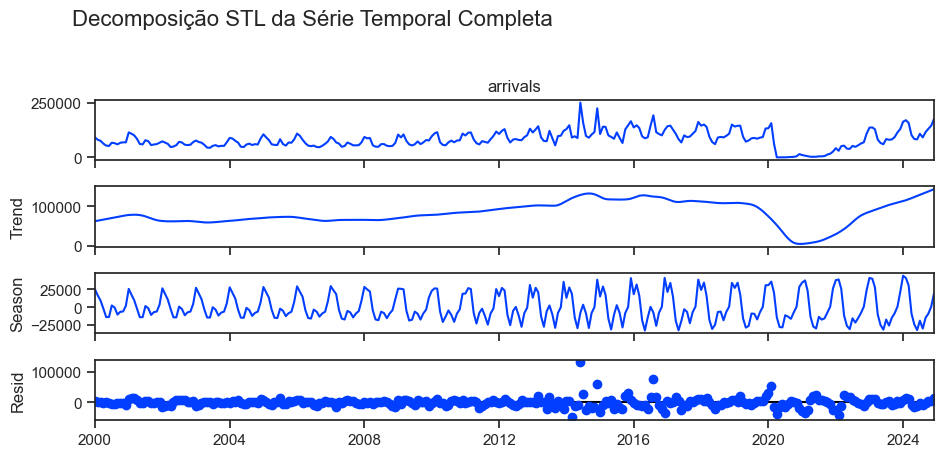

In [5]:
# Realiza a decomposição STL na série temporal completa

stl_total = STL(data_series, period=12, seasonal=13)
result_total = stl_total.fit()

# Plota os componentes da decomposição (tendência, sazonalidade, resíduo)
fig = result_total.plot()
fig.suptitle('Decomposição STL da Série Temporal Completa', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1.5, 0.95]) # Ajusta o layout para evitar sobreposição do título
plt.show()

Definir Período da covid.

In [6]:
PRE_COVID_END = '2020-02-29' # Último dia antes do impacto
COVID_START = '2020-03-01' # Primeiro dia do impacto
COVID_END = '2023-05-01'   # Último dia do período a ser imputado
dados_pre_covid = data_series.loc[:PRE_COVID_END].copy()

Projetar Componente Sazonalidade, Tendência e Combiná-los para imputar o período da covid

In [7]:
stl = STL(dados_pre_covid, period=12, seasonal=13).fit()

ultimo_ano_sazonal = stl.seasonal[-12:]
indice_gap_covid = data_series.loc[COVID_START:COVID_END].index
n_meses_gap = len(indice_gap_covid)

n_repeticoes = int(np.ceil(n_meses_gap / 12))
valores_sazonais_projetados = np.tile(ultimo_ano_sazonal.values, n_repeticoes)[:n_meses_gap]

sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap_covid)


segmento_tendencia_recente = stl.trend.dropna().iloc[-12:]

x = np.arange(len(segmento_tendencia_recente))
y = segmento_tendencia_recente.values
coefs = np.polyfit(x, y, 1) # Retorna [slope, intercept]
slope = coefs[0]

ultimo_valor_tendencia = segmento_tendencia_recente.iloc[-1]
x_projecao = np.arange(1, n_meses_gap + 1)
valores_tendencia_projetados = (slope * x_projecao) + ultimo_valor_tendencia

tendencia_imputada = pd.Series(valores_tendencia_projetados, index=indice_gap_covid)


valores_imputados = tendencia_imputada + sazonal_imputado
data_series_imputada = data_series.copy()
data_series_imputada.loc[COVID_START:COVID_END] = valores_imputados

Projetar Média das Componentes Sazonalidade, Tendência e Combiná-los para imputar o período da covid

In [8]:
# Calcula a média da sazonalidade para cada mês do ano a partir do período pré-COVID
media_sazonal_mensal = stl.seasonal.groupby(stl.seasonal.index.month).mean()

# Mapeia a média sazonal de cada mês para o período de gap da COVID
sazonalidade_imputada_media = pd.Series(
    indice_gap_covid.month.map(media_sazonal_mensal), 
    index=indice_gap_covid
)

# Calcula a média do componente de tendência do período pré-COVID
media_tendencia = stl.trend.dropna().mean()

# Cria uma série constante com a média da tendência para o período de gap
tendencia_imputada_media = pd.Series(media_tendencia, index=indice_gap_covid)

# Soma os componentes de tendência e sazonalidade para obter os valores imputados
valores_imputados_media = tendencia_imputada_media + sazonalidade_imputada_media

# Cria uma nova série temporal e preenche o período da COVID com os valores imputados
data_series_imputada_media = data_series.copy()
data_series_imputada_media.loc[COVID_START:COVID_END] = valores_imputados_media

Imputação pelo AutoETS

In [9]:
# Prepara o DataFrame de treino (pré-COVID) no formato esperado pelo StatsForecast
df_pre_covid_sf = pd.DataFrame({
    'unique_id': 'rj',
    'ds': dados_pre_covid.index,
    'y': dados_pre_covid.values
})

# Inicializa e treina o modelo AutoETS com os dados pré-COVID
sf_ets = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
sf_ets.fit(df=df_pre_covid_sf)

# Faz a previsão para o período do gap da COVID
# O horizonte (h) é o número de meses a serem imputados
forecast_ets = sf_ets.forecast(df=df_pre_covid_sf,h=n_meses_gap)

# Cria uma Série com os valores previstos, usando o índice do período da COVID
valores_imputados_ets = pd.Series(forecast_ets['AutoETS'].values, index=indice_gap_covid)

# Cria uma cópia da série original e substitui o período da COVID pelos valores imputados
data_series_imputada_ets = data_series.copy()
data_series_imputada_ets.loc[COVID_START:COVID_END] = valores_imputados_ets

Plot da Comparação das Imputações com o Período Original.

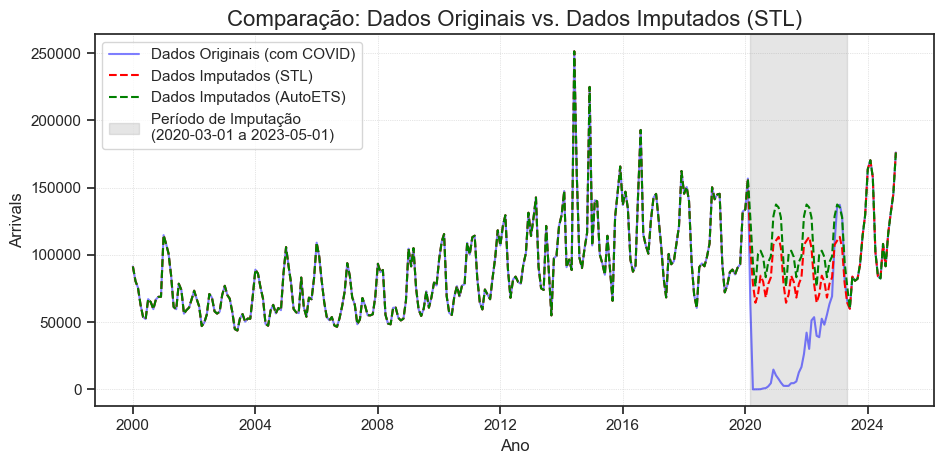

In [10]:
plt.plot(data_series.index, data_series, label='Dados Originais (com COVID)', 
         color='blue', alpha=0.5)

# Plota os novos dados imputados
plt.plot(data_series_imputada_media.index, data_series_imputada_media, 
         label='Dados Imputados (STL)', 
         color='red', linestyle='--')

plt.plot(data_series_imputada_ets.index, data_series_imputada_ets, 
         label='Dados Imputados (AutoETS)', 
         color='green', linestyle='--')

# Destaca a área que foi imputada
plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
            color='gray', alpha=0.2, label=f'Período de Imputação\n({COVID_START} a {COVID_END})')

plt.title('Comparação: Dados Originais vs. Dados Imputados (STL)', fontsize=16)
plt.ylabel(data_series.name.capitalize() if data_series.name else 'Valores')
plt.xlabel('Ano')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout(rect=[0,0,1.5,1])
plt.show()

ETS Python

Modelo Selecionado:  ETS(M,A,M)

RMSE (Treino): 17394.06
MAPE (Treino): 11.78%
MAE (Treino): 10663.43

RMSE (2024): 33118.92
MAPE (2024): 20.45%
MAE (2024): 28220.77


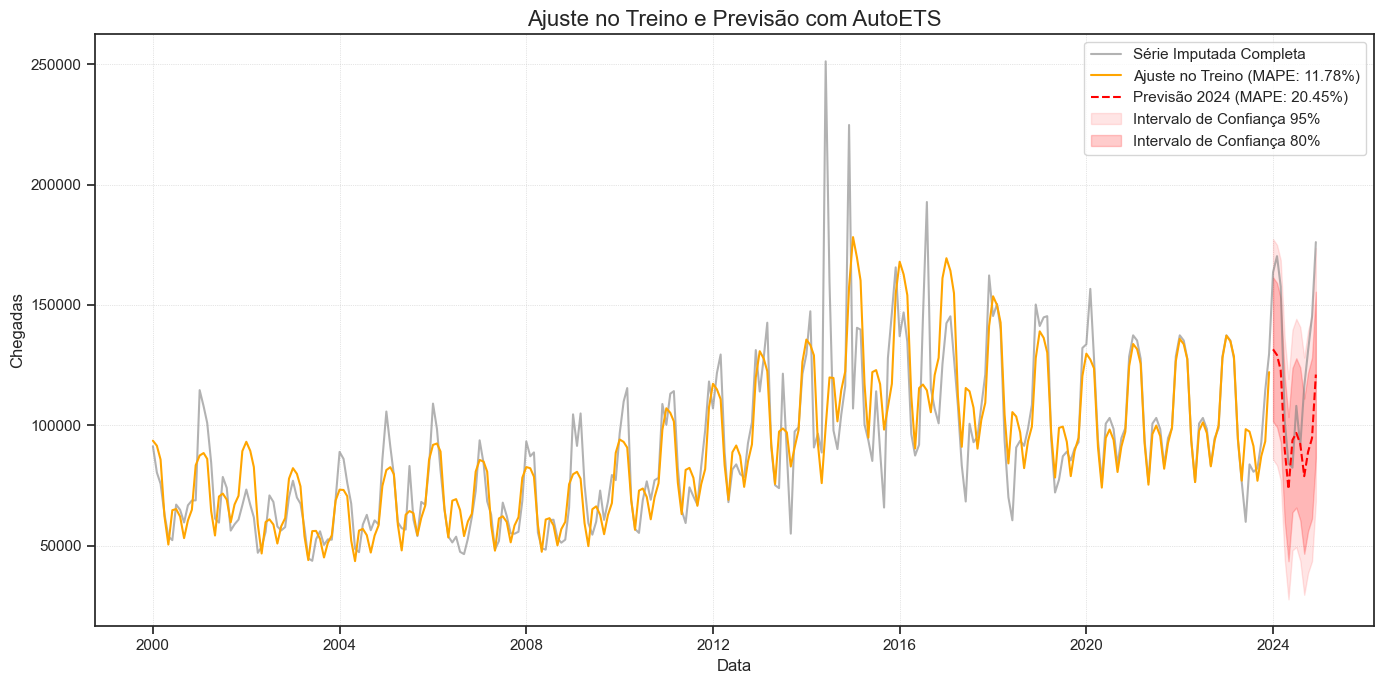

In [11]:
# Treino até 2023-12-31 e teste em 2024, treino ETS via AutoETS (statsforecast) e previsão
train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-12-31'

# Série de treino e teste a partir da série já imputada
train_series = data_series_imputada_ets.loc[:train_end].copy()
test_series = data_series_imputada_ets.loc[test_start:test_end].copy()

# Prepara DataFrame no formato esperado pelo StatsForecast (unique_id, ds, y)
df_sf = pd.DataFrame({
    'unique_id': 'rj',
    'ds': train_series.index,
    'y': train_series.values
})

# Inicializa o objeto StatsForecast com AutoETS
sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)

sf.fit(df=df_sf)

# Chamada correta: passar o DataFrame como argumento para forecast()
forecasts = sf.forecast(df=df_sf, h=12, level=[80,95], fitted=True)

# Identifica a coluna de previsão (pode variar de nome conforme versão)
pred_col = [c for c in forecasts.columns if c not in ('unique_id', 'ds')][0]

# Series de previsão alinhada com as datas do horizonte
pred_index = pd.to_datetime(forecasts['ds'])
y_pred_teste = forecasts[pred_col].values

# Valores s (verdadeiros) para 2024 alinhados com o índice de previsão
y_true_teste = test_series.reindex(pred_index).values

# Métricas
rmse_val = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste))
mape_val = mean_absolute_percentage_error(y_true_teste, y_pred_teste) * 100
mae_val = mean_absolute_error(y_true_teste, y_pred_teste)

# Extrai as previsões in-sample (ajuste no treino)
fitted_values_df = sf.forecast_fitted_values()

# Alinha os valores verdadeiros do treino com as previsões
y_true_treino = df_sf['y'].values
y_pred_treino = fitted_values_df['AutoETS'].values

# Métricas para o período de treino
rmse_treino = np.sqrt(mean_squared_error(y_true_treino, y_pred_treino))
mape_treino = mean_absolute_percentage_error(y_true_treino, y_pred_treino) * 100
mae_treino = mean_absolute_error(y_true_treino, y_pred_treino)

print("Modelo Selecionado: ", sf.fitted_[0][0].model_['method'])

print(f"\nRMSE (Treino): {rmse_treino:.2f}")
print(f"MAPE (Treino): {mape_treino:.2f}%")
print(f"MAE (Treino): {mae_treino:.2f}")

print(f"\nRMSE (2024): {rmse_val:.2f}")
print(f"MAPE (2024): {mape_val:.2f}%")
print(f"MAE (2024): {mae_val:.2f}")

# Plot
plt.figure(figsize=(14, 7))

# Plot da série completa imputada
plt.plot(data_series_imputada_ets.index, data_series_imputada_ets.values, 
         label='Série Imputada Completa', color='gray', alpha=0.6)

# Plot dos valores ajustados no treino
plt.plot(fitted_values_df['ds'], fitted_values_df['AutoETS'].values, 
         label=f'Ajuste no Treino (MAPE: {mape_treino:.2f}%)', color='orange')

# Plot da previsão para o período de teste
plt.plot(pred_index, y_pred_teste, 
         label=f'Previsão 2024 (MAPE: {mape_val:.2f}%)', color='red', linestyle='--')

# Intervalos de confiança
plt.fill_between(pred_index, forecasts['AutoETS-lo-95'], forecasts['AutoETS-hi-95'], 
                 color='red', alpha=0.1, label='Intervalo de Confiança 95%')
plt.fill_between(pred_index, forecasts['AutoETS-lo-80'], forecasts['AutoETS-hi-80'], 
                 color='red', alpha=0.2, label='Intervalo de Confiança 80%')

plt.title('Ajuste no Treino e Previsão com AutoETS', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Chegadas')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


IMPORTANTE

'method' extrai o método utilizado pelo AutoETS - (sf.fitted_[0][0].model_['method'])

'arma' acessa quais os parametros do modelo foram utilizados pelo AutoARIMA - (sf_arima_residuos.fitted_[0][0].model_['arma'])

'residuals' são os resíduos padronizados (innovation residuals) - (sf.fitted_[0][0].model_['residuals'])

'actual_residuals' são os resíduos na escala original (y - y_hat); - (sf.fitted_[0][0].model_['actual_residuals'])

Análise dos resíduos

--- Análise de Resíduos ---

1. Teste T para Média Zero:
   Estatística t: 0.6672
   p-valor: 0.5052
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0001
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.05).

3. Teste de Jarque-Bera (Normalidade):
   Estatística: 5516.7404
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.9941
   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).


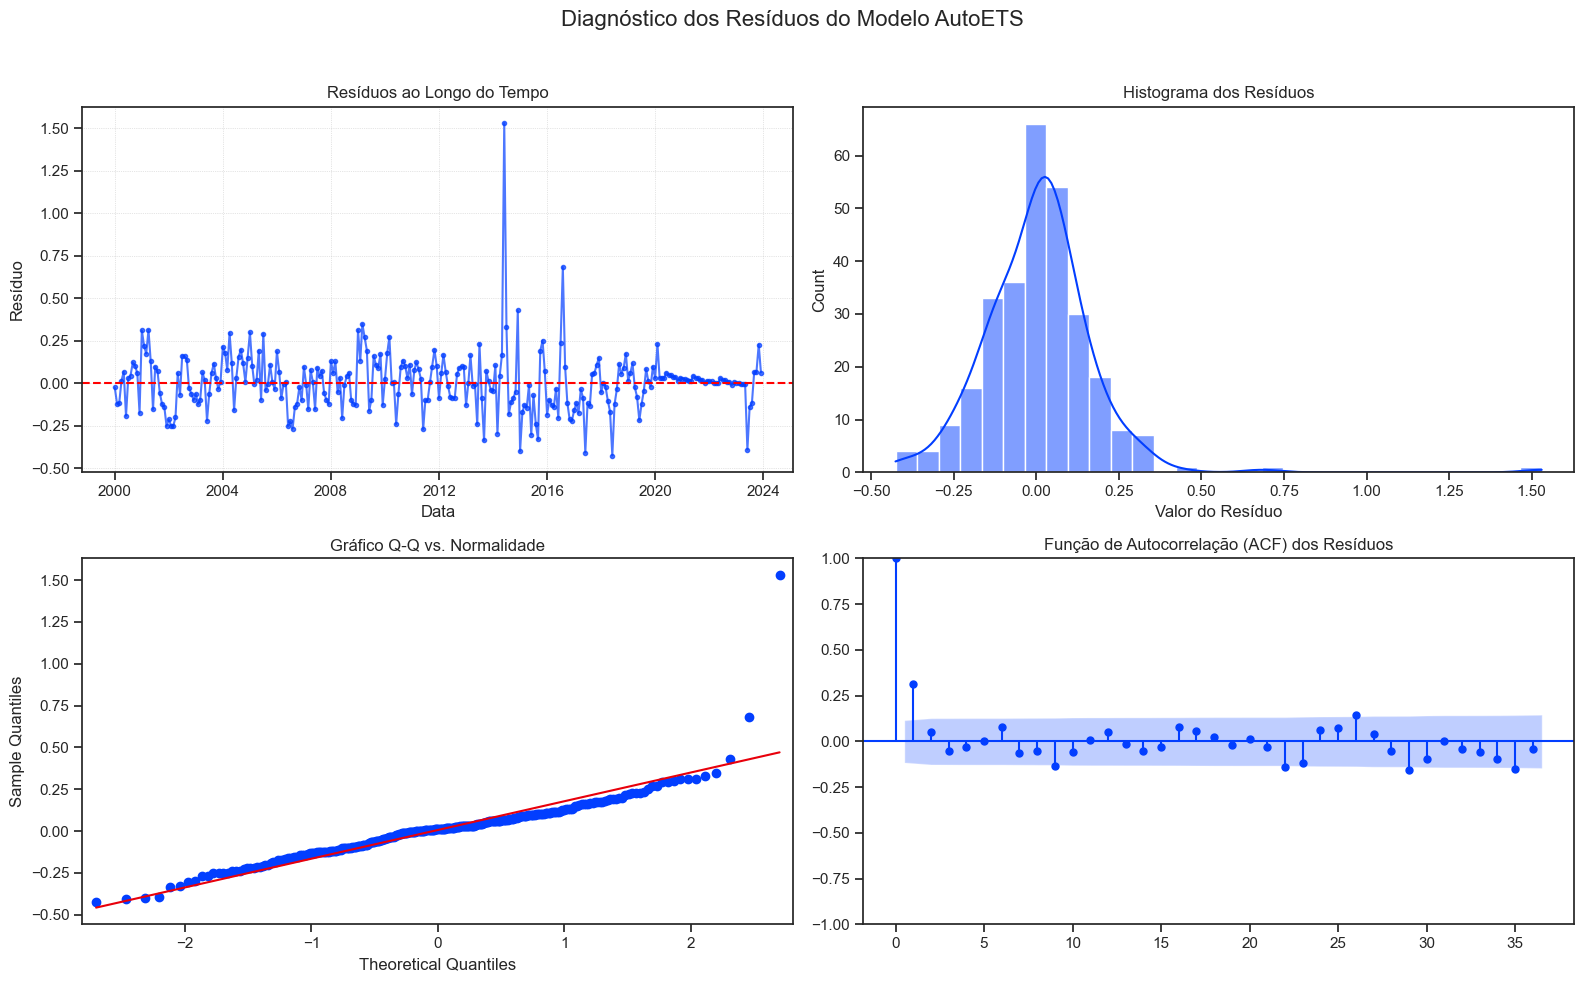

In [12]:
# --- Residual Diagnostics (Training Set) ---
print("--- Análise de Resíduos ---")

# 1. Teste T para Média Zero
print("\n1. Teste T para Média Zero:")
if len(sf.fitted_[0][0].model_['residuals']) > 1:
    t_stat, t_pvalue = ttest_1samp(sf.fitted_[0][0].model_['residuals'], 0)
    print(f"   Estatística t: {t_stat:.4f}")
    print(f"   p-valor: {t_pvalue:.4f}")
    if t_pvalue > 0.05:
        print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).")
    else:
        print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero (p < 0.05).")
        if sf.fitted_[0][0].model_['residuals'].mean() > 0:
            print("   → O modelo tende a SUBESTIMAR os valores reais.")
        else:
            print("   → O modelo tende a SUPERESTIMAR os valores reais.")
else:
    print("   Não foi possível realizar o Teste T (dados insuficientes).")


# 2. Teste de Ljung-Box para Autocorrelação
print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
if len(sf.fitted_[0][0].model_['residuals']) > 24:
    lb_test = acorr_ljungbox(sf.fitted_[0][0].model_['residuals'], lags=[24], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   p-valor: {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos (p > 0.05).")
    else:
        print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

# 3. Teste de Jarque-Bera para Normalidade
print("\n3. Teste de Jarque-Bera (Normalidade):")
if len(sf.fitted_[0][0].model_['residuals']) > 1:
    jb_stat, jb_pvalue = stats.jarque_bera(sf.fitted_[0][0].model_['residuals'])
    print(f"   Estatística: {jb_stat:.4f}")
    print(f"   p-valor: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos (p > 0.05).")
    else:
        print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Jarque-Bera (dados insuficientes).")

# 4. Teste ARCH para Heterocedasticidade
print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
try:
    arch_test = het_arch(sf.fitted_[0][0].model_['residuals'], nlags=12)
    arch_pvalue = arch_test[1]
    print(f"   p-valor: {arch_pvalue:.4f}")
    if arch_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).")
    else:
        print("   ✗ FALHA: Heterocedasticidade detectada (p < 0.05).")
except Exception as e:
    print(f"   Não foi possível realizar o Teste ARCH: {e}")


# --- Plots de Diagnóstico ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Diagnóstico dos Resíduos do Modelo AutoETS', fontsize=16)

# Plot 1: Resíduos ao longo do tempo
axes[0, 0].plot(train_series.index, sf.fitted_[0][0].model_['residuals'], marker='o', linestyle='-', markersize=3, alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Resíduos ao Longo do Tempo')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduo')
axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

# Plot 2: Histograma dos resíduos
sns.histplot(sf.fitted_[0][0].model_['residuals'], kde=True, ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Histograma dos Resíduos')
axes[0, 1].set_xlabel('Valor do Resíduo')

# Plot 3: Gráfico Q-Q (Quantil-Quantil)
sm.qqplot(sf.fitted_[0][0].model_['residuals'], line='s', ax=axes[1, 0])
axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

# Plot 4: Gráfico de Autocorrelação (ACF), e PACF
sm.graphics.tsa.plot_acf(sf.fitted_[0][0].model_['residuals'], ax=axes[1, 1], lags=36)
axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Nenhum dos modelos ETS passa no teste de Ljung-Box, logo não há autocorrelação entre os resíduos e os modelos ETS não são úteis para modelar, então inovaremos com o modelo Hibrido (ETS + ARIMA nos resíduos).

--- Construindo Modelo Híbrido (ETS + ARIMA nos Resíduos) ---

--- Comparação de Performance no Período de Teste (2024) ---
AutoETS       -> RMSE: 33118.92, MAPE: 20.45%, MAE: 28220.77
Híbrido (ETS+ARIMA) -> RMSE: 32881.41, MAPE: 20.30%, MAE: 27981.80


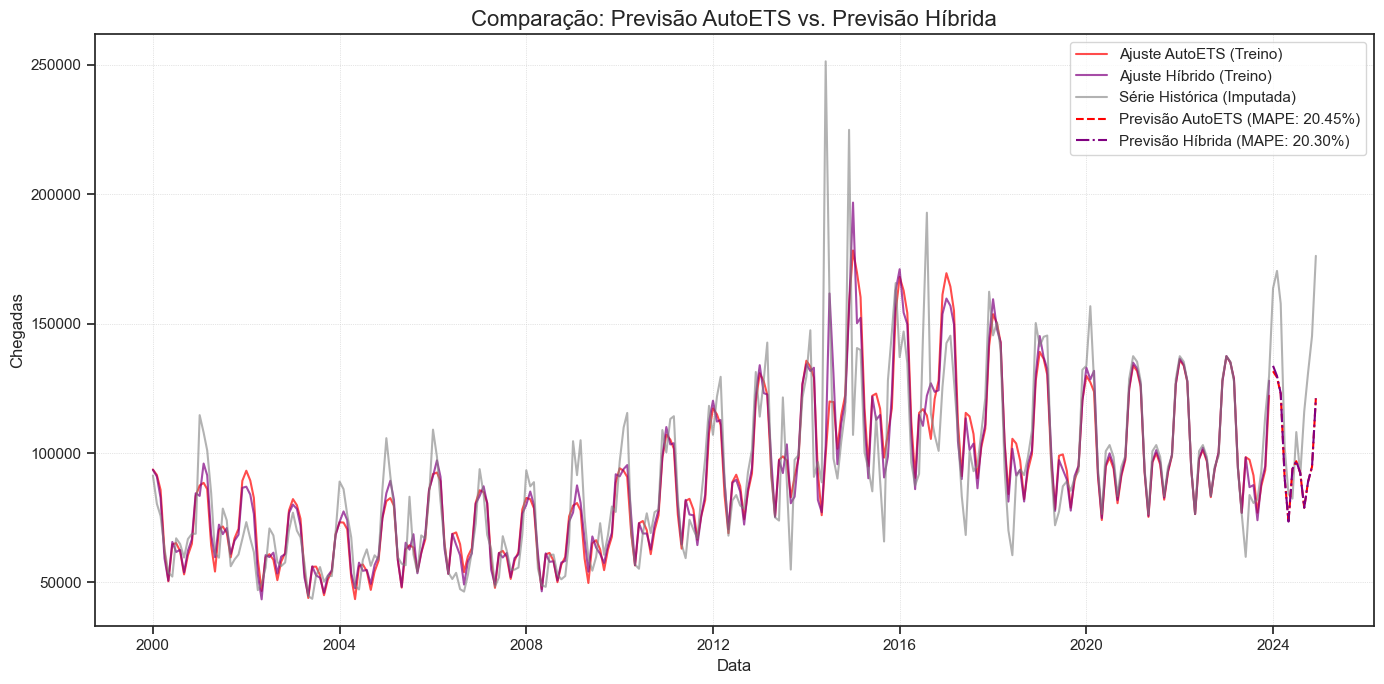

In [13]:
# --- Modelo Híbrido: ETS + ARIMA nos Resíduos ---
print("--- Construindo Modelo Híbrido (ETS + ARIMA nos Resíduos) ---")

# 1. Preparar DataFrame com os resíduos do modelo AutoETS anterior
df_residuos = pd.DataFrame({
    'unique_id': 'rj_residuos',
    'ds': train_series.index,
    'y': sf.fitted_[0][0].model_['actual_residuals']
})

# 2. Treinar um modelo AutoARIMA nos resíduos
# O objetivo é capturar qualquer padrão remanescente nos resíduos do ETS
sf_arima_residuos = StatsForecast(
    models=[AutoARIMA(season_length=12)], 
    freq='MS', 
    n_jobs=-1
)
sf_arima_residuos.fit(df=df_residuos)

# 3. Fazer a previsão dos resíduos para o período de teste (h=12)
forecast_residuos = sf_arima_residuos.forecast(df=df_residuos, h=12, fitted=True)


# Opcional: Criar a previsão do ARIMA para o conjunto de treino (fitted values)
fitted_residuos = sf_arima_residuos.forecast_fitted_values()

y_pred_treino_hibrido = fitted_residuos['AutoARIMA'].values + y_pred_treino


# 4. Criar a previsão do modelo híbrido
# Previsão Híbrida = Previsão do ETS + Previsão dos Resíduos
y_pred_teste_hibrido = y_pred_teste + forecast_residuos['AutoARIMA'].values

# 5. Calcular as métricas de erro para o modelo híbrido
rmse_hibrido = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste_hibrido))
mape_hibrido = mean_absolute_percentage_error(y_true_teste, y_pred_teste_hibrido) * 100
mae_hibrido = mean_absolute_error(y_true_teste, y_pred_teste_hibrido)

print("\n--- Comparação de Performance no Período de Teste (2024) ---")
print(f"AutoETS       -> RMSE: {rmse_val:.2f}, MAPE: {mape_val:.2f}%, MAE: {mae_val:.2f}")
print(f"Híbrido (ETS+ARIMA) -> RMSE: {rmse_hibrido:.2f}, MAPE: {mape_hibrido:.2f}%, MAE: {mae_hibrido:.2f}")


# 6. Plotar os resultados para comparação
plt.figure(figsize=(14, 7))
# Plot do ajuste no treino do AutoETS
plt.plot(train_series.index, y_pred_treino, 
         label='Ajuste AutoETS (Treino)', color='red', alpha=0.7)

# Plot do ajuste no treino do Modelo Híbrido
plt.plot(train_series.index, y_pred_treino_hibrido, 
         label='Ajuste Híbrido (Treino)', color='purple', alpha=0.7)

# Plot da série completa imputada
plt.plot(data_series_imputada_ets.index, data_series_imputada_ets.values, 
         label='Série Histórica (Imputada)', color='gray', alpha=0.6)

# Plot da previsão original do AutoETS
plt.plot(pred_index, y_pred_teste, 
         label=f'Previsão AutoETS (MAPE: {mape_val:.2f}%)', color='red', linestyle='--')

# Plot da previsão do modelo híbrido
plt.plot(pred_index, y_pred_teste_hibrido, 
         label=f'Previsão Híbrida (MAPE: {mape_hibrido:.2f}%)', color='purple', linestyle='-.')

plt.title('Comparação: Previsão AutoETS vs. Previsão Híbrida', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Chegadas')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [14]:
len(y_pred_treino)

288

Modelo ARIMA (1, 0, 0, 0, 1, 0, 0)

--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---

1. Teste T para Média Zero:
   Estatística t: 0.0341
   p-valor: 0.9728
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.1811
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos (p > 0.05).

3. Teste de Jarque-Bera (Normalidade):
   Estatística: 7628.8094
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0016
   ✗ FALHA: Heterocedasticidade detectada (p < 0.05).


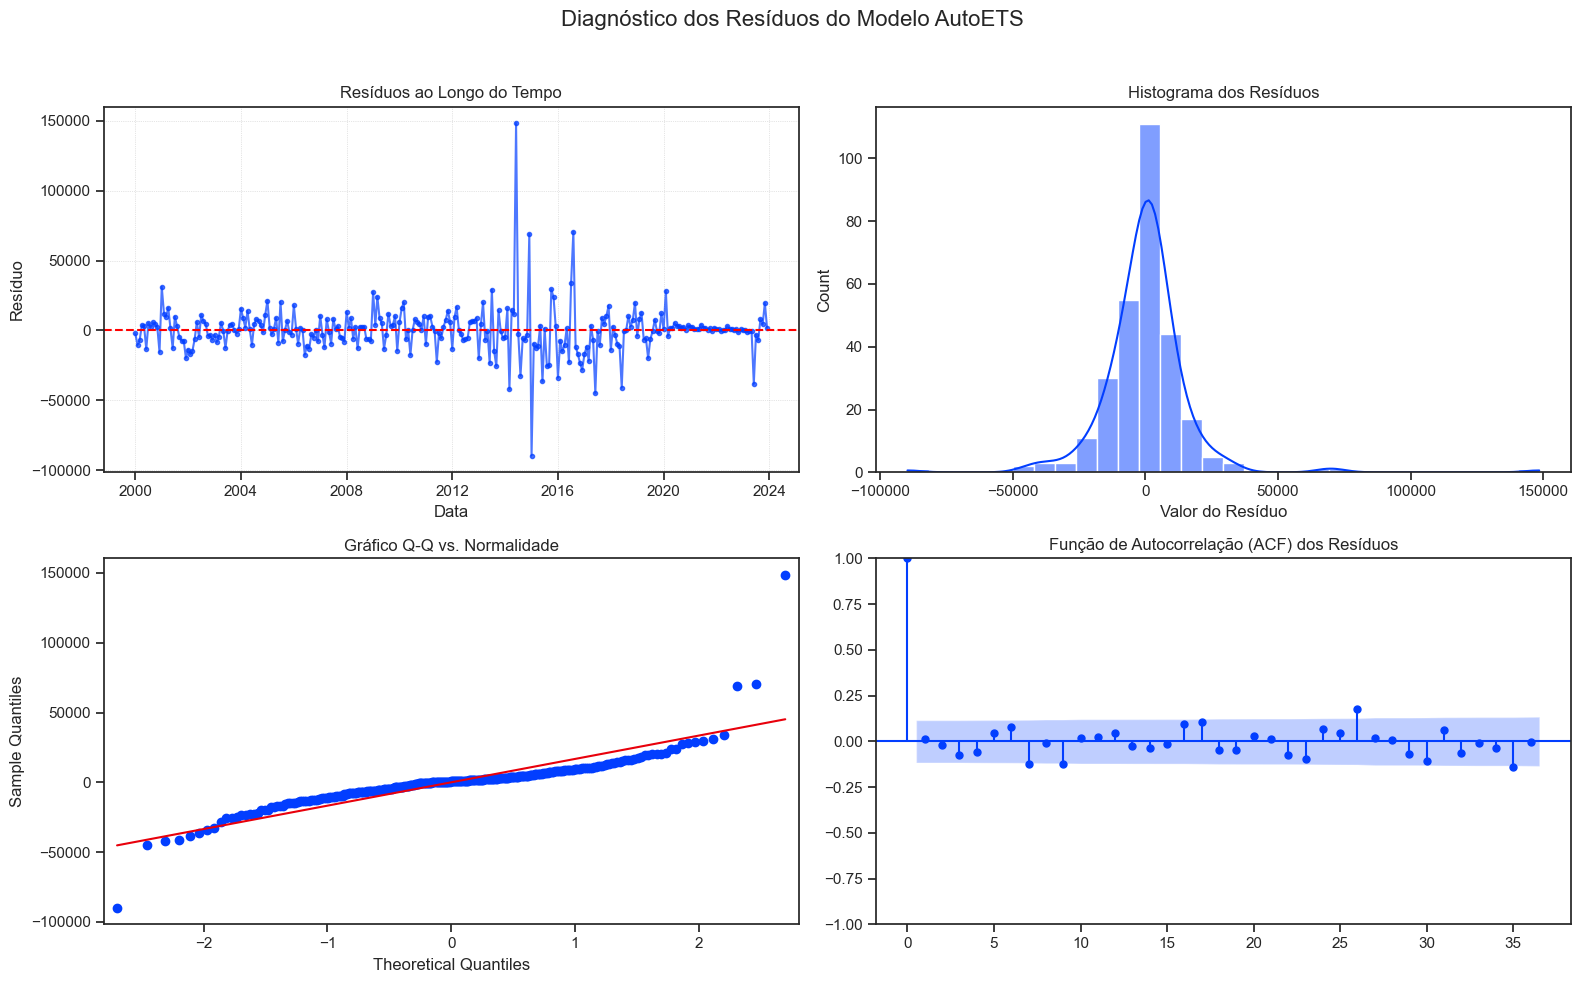

In [15]:
print("Modelo ARIMA", sf_arima_residuos.fitted_[0][0].model_['arma'])

print("\n--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---")

residuos_hibrido_treino = y_true_treino - y_pred_treino_hibrido

# 1. Teste T para Média Zero
print("\n1. Teste T para Média Zero:")
if len(residuos_hibrido_treino) > 1:
    t_stat, t_pvalue = ttest_1samp(residuos_hibrido_treino, 0)
    print(f"   Estatística t: {t_stat:.4f}")
    print(f"   p-valor: {t_pvalue:.4f}")
    if t_pvalue > 0.05:
        print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).")
    else:
        print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero (p < 0.05).")
        if sf.fitted_[0][0].model_['residuals'].mean() > 0:
            print("   → O modelo tende a SUBESTIMAR os valores reais.")
        else:
            print("   → O modelo tende a SUPERESTIMAR os valores reais.")
else:
    print("   Não foi possível realizar o Teste T (dados insuficientes).")


# 2. Teste de Ljung-Box para Autocorrelação
print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
if len(residuos_hibrido_treino) > 24:
    lb_test = acorr_ljungbox(residuos_hibrido_treino, lags=[24], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   p-valor: {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos (p > 0.05).")
    else:
        print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

# 3. Teste de Jarque-Bera para Normalidade
print("\n3. Teste de Jarque-Bera (Normalidade):")
if len(residuos_hibrido_treino) > 1:
    jb_stat, jb_pvalue = stats.jarque_bera(residuos_hibrido_treino)
    print(f"   Estatística: {jb_stat:.4f}")
    print(f"   p-valor: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos (p > 0.05).")
    else:
        print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Jarque-Bera (dados insuficientes).")

# 4. Teste ARCH para Heterocedasticidade
print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
try:
    arch_test = het_arch(residuos_hibrido_treino, nlags=12)
    arch_pvalue = arch_test[1]
    print(f"   p-valor: {arch_pvalue:.4f}")
    if arch_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).")
    else:
        print("   ✗ FALHA: Heterocedasticidade detectada (p < 0.05).")
except Exception as e:
    print(f"   Não foi possível realizar o Teste ARCH: {e}")


# --- Plots de Diagnóstico ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Diagnóstico dos Resíduos do Modelo AutoETS', fontsize=16)

# Plot 1: Resíduos ao longo do tempo
axes[0, 0].plot(train_series.index, residuos_hibrido_treino, marker='o', linestyle='-', markersize=3, alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Resíduos ao Longo do Tempo')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduo')
axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

# Plot 2: Histograma dos resíduos
sns.histplot(residuos_hibrido_treino, kde=True, ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Histograma dos Resíduos')
axes[0, 1].set_xlabel('Valor do Resíduo')

# Plot 3: Gráfico Q-Q (Quantil-Quantil)
sm.qqplot(residuos_hibrido_treino, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

# Plot 4: Gráfico de Autocorrelação (ACF), e PACF
sm.graphics.tsa.plot_acf(residuos_hibrido_treino, ax=axes[1, 1], lags=36)
axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Concatena os continentes

In [16]:
df_rj_continente = process_df(df=df, state="rio_de_janeiro", agg_cols=["date","continent","continent_id"], value_cols="arrivals", agg_func="sum")
df_rj_continente.tail()

date         continent  continent_id  arrivals
2095 2024-12-01  america_do_norte             3   29679.0
2096 2024-12-01    america_do_sul             4   99840.0
2097 2024-12-01              asia             5    2651.0
2098 2024-12-01            europa             6   39981.0
2099 2024-12-01           oceania             7    1623.0

Separa os continentes

In [17]:
# Pivota o dataframe para que cada continente seja uma coluna, com a data como índice
df_continentes_pivot = df_rj_continente.pivot(
    index='date', 
    columns='continent', 
    values='arrivals'
)

# Cria um dicionário onde cada chave é o nome de um continente e o valor é a série temporal correspondente
series_por_continente = {
    continente: df_continentes_pivot[continente] for continente in df_continentes_pivot.columns
}

# Exibe as primeiras 5 linhas do dataframe pivotado para verificação
print("DataFrame Pivotado (cada coluna é uma série temporal):")
print(df_continentes_pivot.head())

# Exemplo de como acessar uma série temporal específica (ex: Europa)
print("\nExemplo de acesso à série da Europa:")
print(series_por_continente['europa'].head())

DataFrame Pivotado (cada coluna é uma série temporal):
continent   africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

continent   america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  

Exemplo de acesso à série da Europa:
date
2000-01-01    41142.0
2000-02-01    36330.0
2000-03-01

Imputando período COVID/Continente

            africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

            america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  


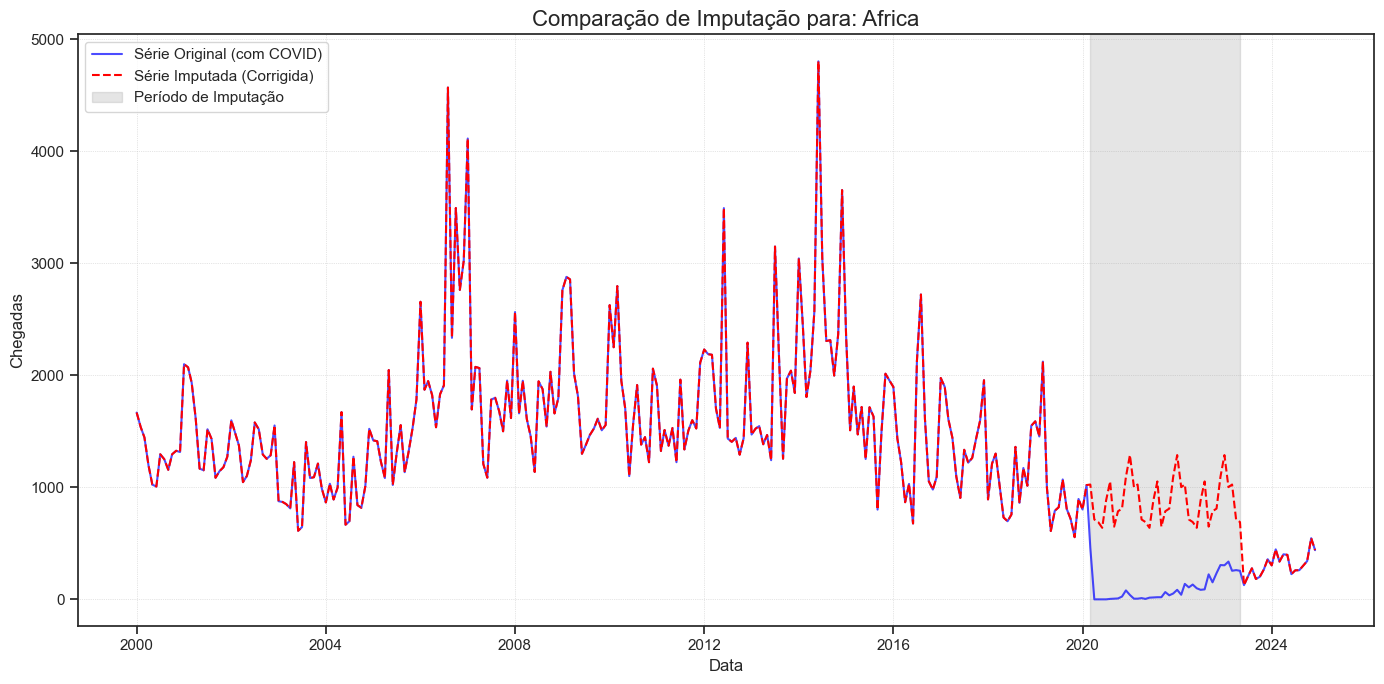

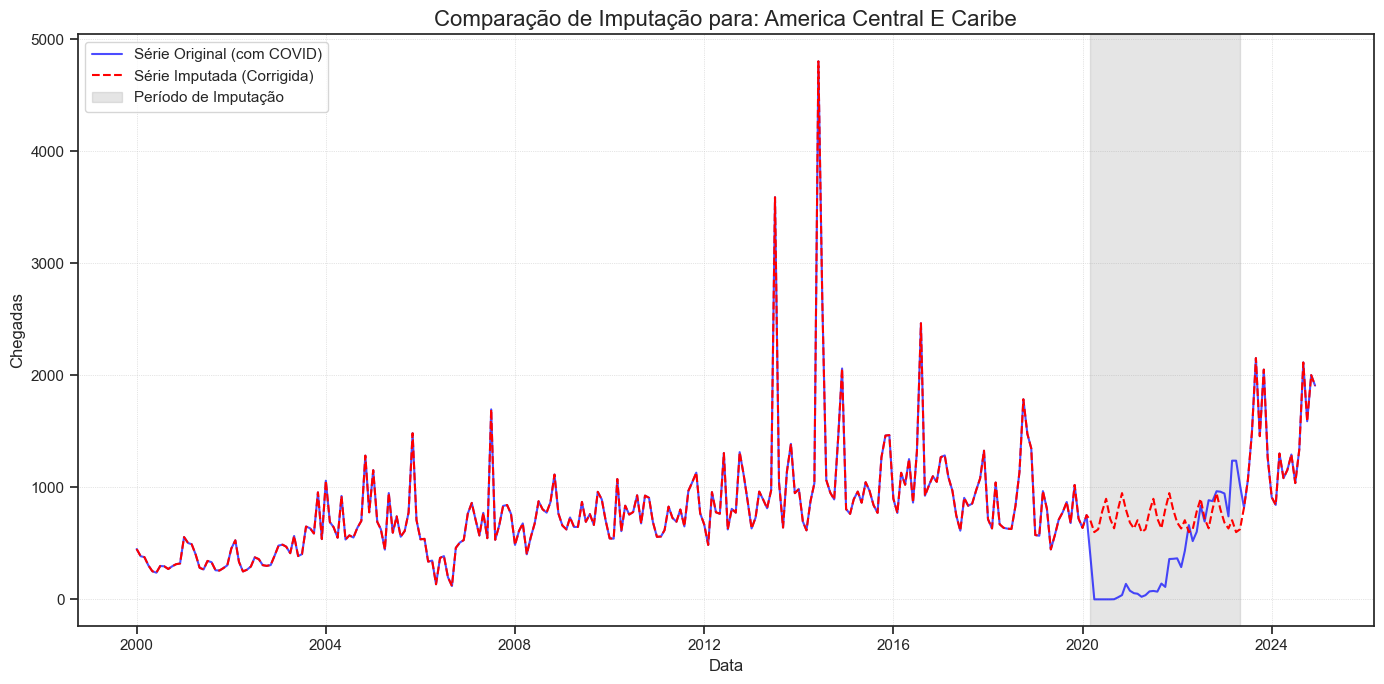

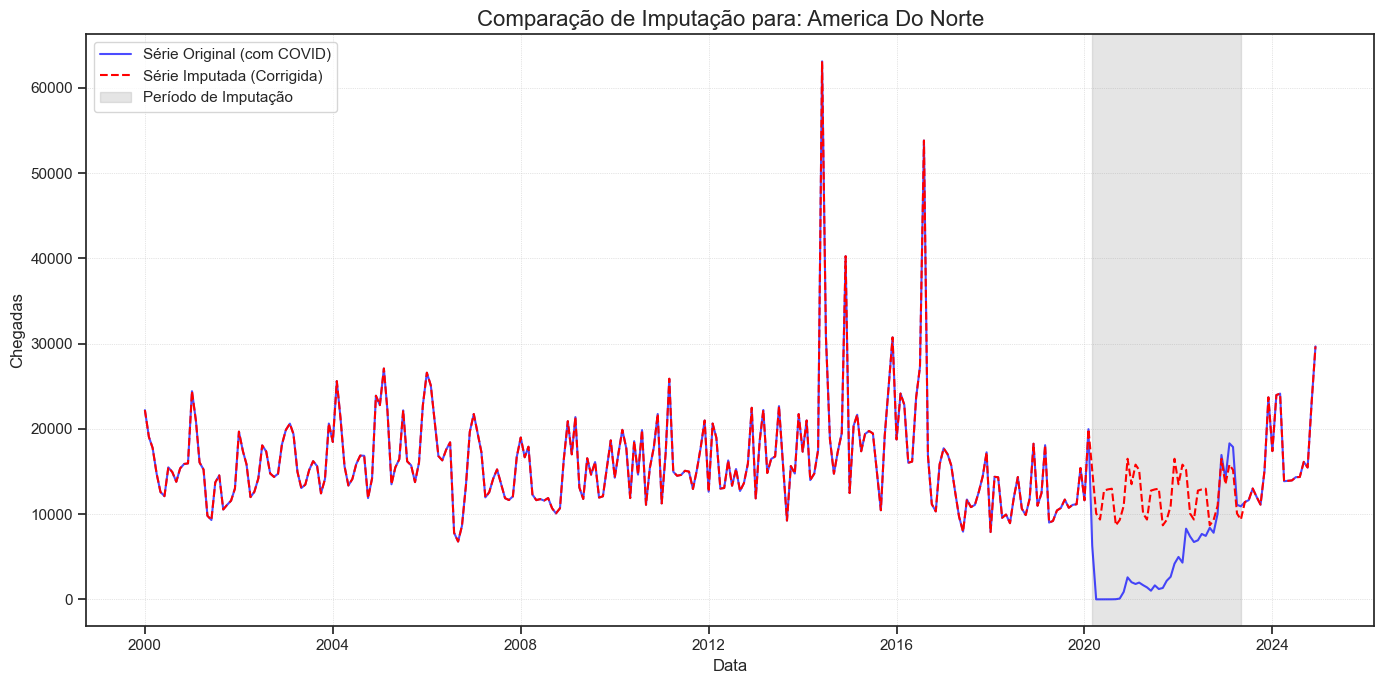

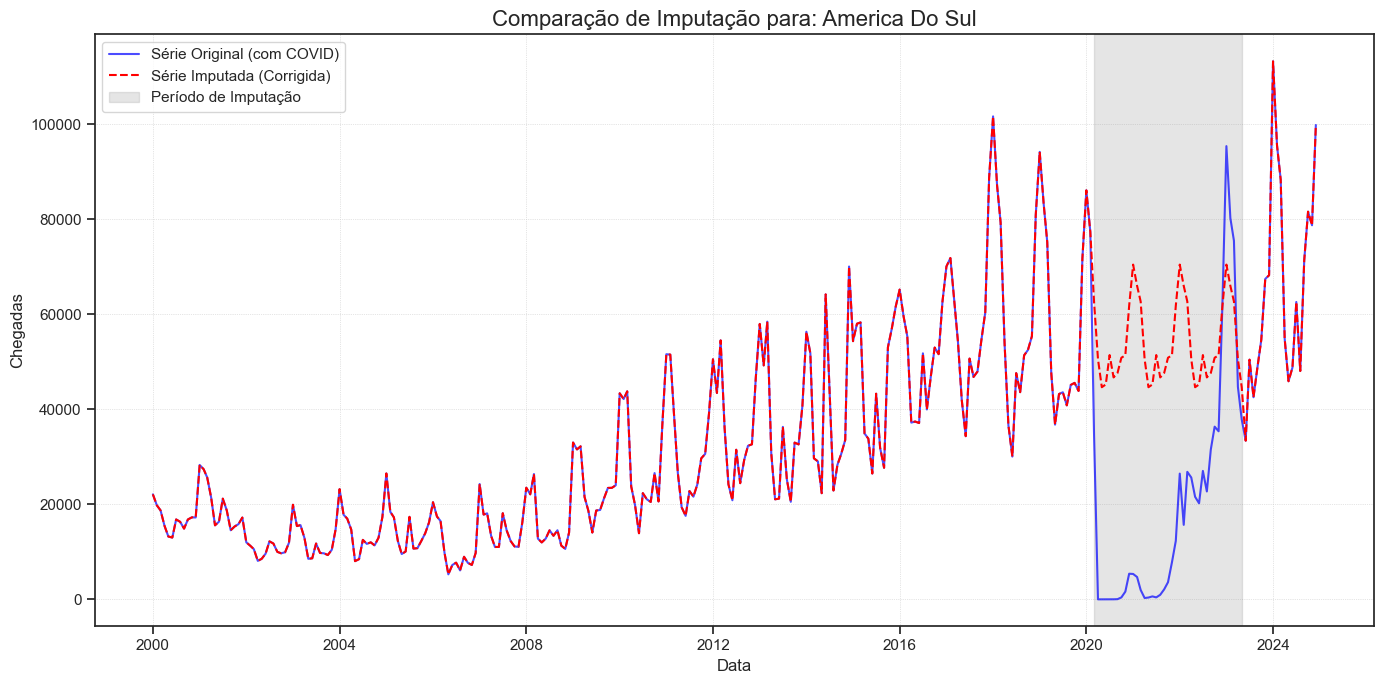

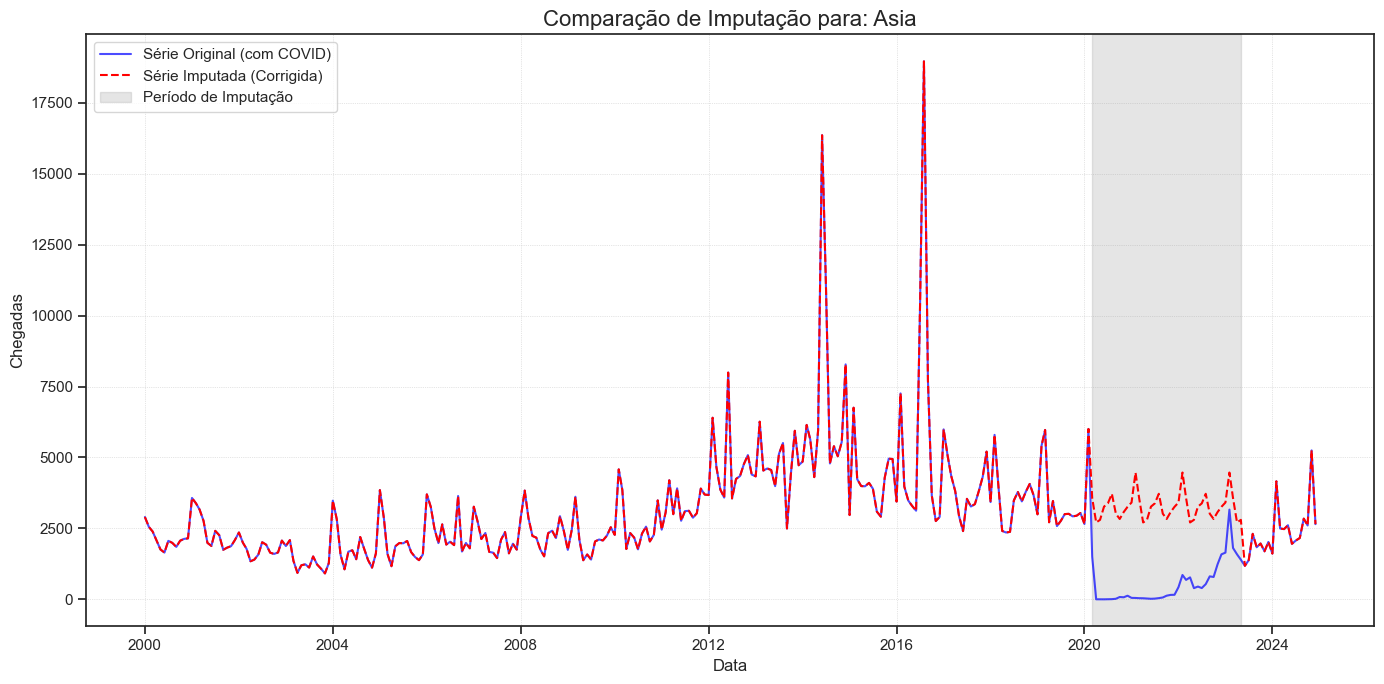

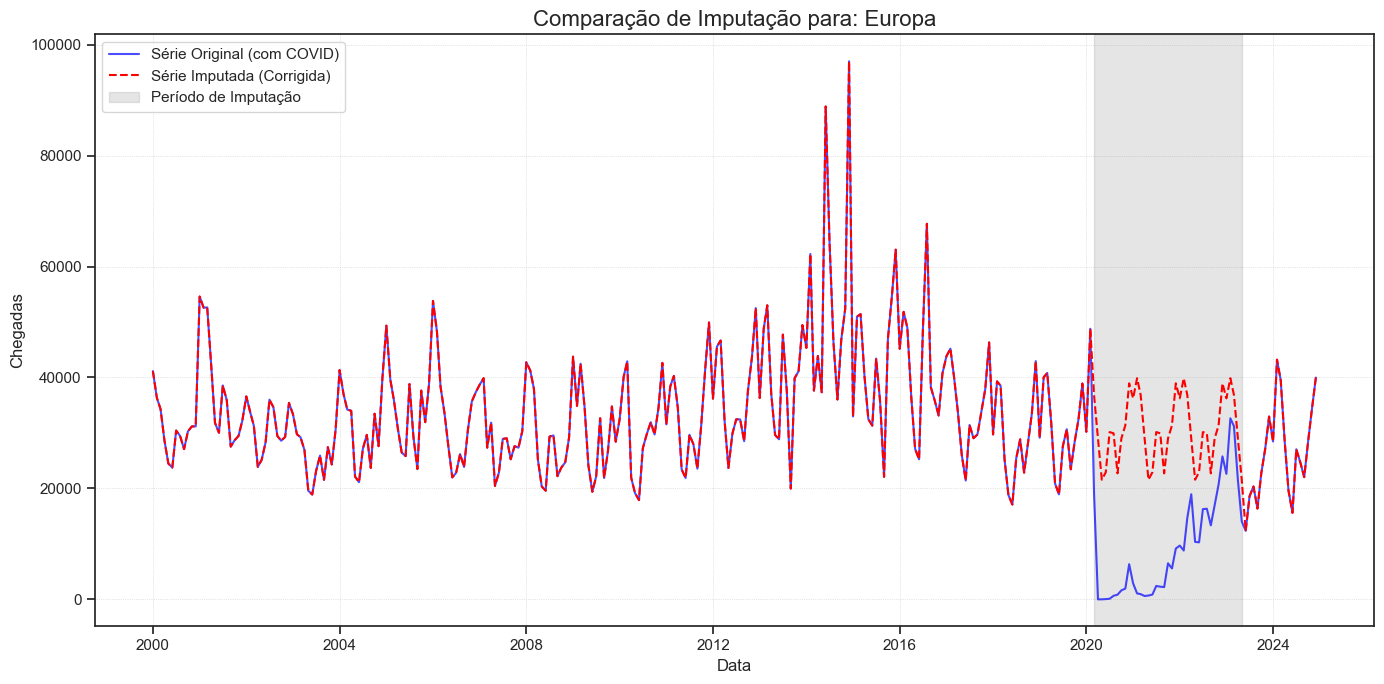

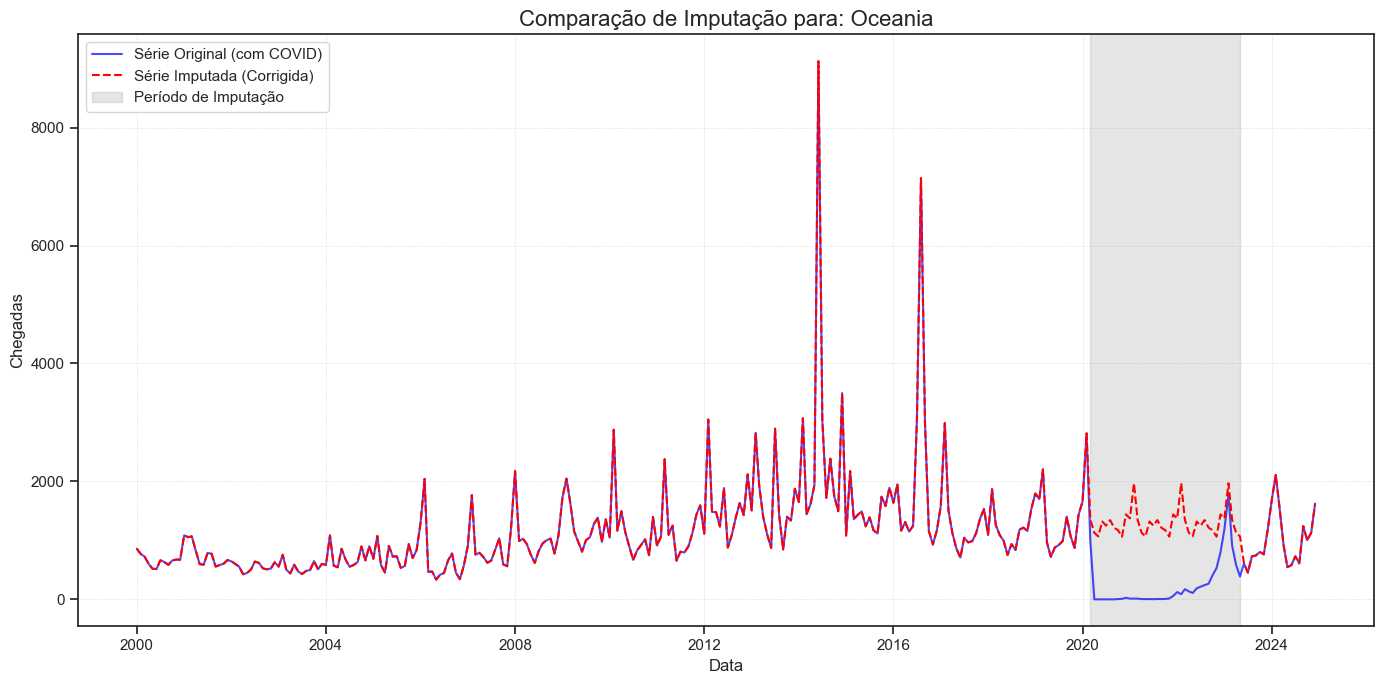

In [18]:
# Imputação do período COVID para cada continente (mesma lógica usada anteriormente)
imputed_continent_series = {}

for continente, serie in series_por_continente.items():
    s = serie.copy()
    # intervalo do gap segundo a série (preserva índice exato)
    indice_gap = s.loc[COVID_START:COVID_END].index
    n_meses_gap = len(indice_gap)
    if n_meses_gap == 0:
        imputed_continent_series[continente] = s
        continue

    # usa apenas pré-COVID para ajustar STL
    pre_covid = s.loc[:PRE_COVID_END].dropna()
    try:
        stl_c = STL(pre_covid, period=12, seasonal=13).fit()

        # --- Componente Sazonal: Média da sazonalidade por mês ---
        # Agrupa a sazonalidade por mês e calcula a média
        sazonalidade_media_mensal = stl_c.seasonal.groupby(stl_c.seasonal.index.month).mean()
        # Mapeia os meses do gap para a sazonalidade média correspondente
        meses_gap = indice_gap.month
        valores_sazonais_projetados = meses_gap.map(sazonalidade_media_mensal).values
        sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap)

        # --- Componente Tendência: Média da tendência dos últimos 12 meses ---
        # Calcula a média dos últimos 12 valores da tendência e a usa como projeção constante
        media_tendencia_recente = stl_c.trend.dropna().iloc[-12:].mean()
        tendencia_imputada = pd.Series(media_tendencia_recente, index=indice_gap)

        # soma tendência + sazonal para obter imputação
        valores_imputados = tendencia_imputada + sazonal_imputado

        s_imputada = s.copy()
        s_imputada.loc[COVID_START:COVID_END] = valores_imputados
        imputed_continent_series[continente] = s_imputada

    except Exception as e:
        # se falhar, mantém a série original e informa
        print(f"Erro ao imputar {continente}: {e}")
        imputed_continent_series[continente] = s

# Monta DataFrame pivotado com séries imputadas (mesmo formato de df_continentes_pivot)
df_continentes_pivot_imputado = pd.DataFrame(imputed_continent_series).sort_index()
df_continentes_pivot_imputado.index.name = 'date'

# Converte para formato longo (ds, unique_id, y) compatível com Y_df_h
Y_df_h_imputado = (
    df_continentes_pivot_imputado
    .reset_index()
    .melt(id_vars='date', var_name='unique_id', value_name='y')
    .rename(columns={'date': 'ds'})
)

# Saída rápida para verificação
print(df_continentes_pivot_imputado.head())

# Plot da comparação para cada continente
for continente, serie_imputada in imputed_continent_series.items():
    serie_original = series_por_continente[continente]
    
    plt.figure(figsize=(14, 7))
    
    # Plota a série original
    plt.plot(serie_original.index, serie_original.values, 
             label='Série Original (com COVID)', color='blue', alpha=0.7)
    
    # Plota a série imputada
    plt.plot(serie_imputada.index, serie_imputada.values, 
             label='Série Imputada (Corrigida)', color='red', linestyle='--')
    
    # Destaca o período de imputação
    plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
                color='gray', alpha=0.2, label=f'Período de Imputação')
    
    # Configurações do gráfico
    plt.title(f'Comparação de Imputação para: {continente.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Chegadas', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()


ETS Continente


--- AFRICA ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 468.15
MAPE (Treino): 22.78%
MAE (Treino): 303.44
RMSE (2024): 124.57
MAPE (2024): 26.91%
MAE (2024): 103.54


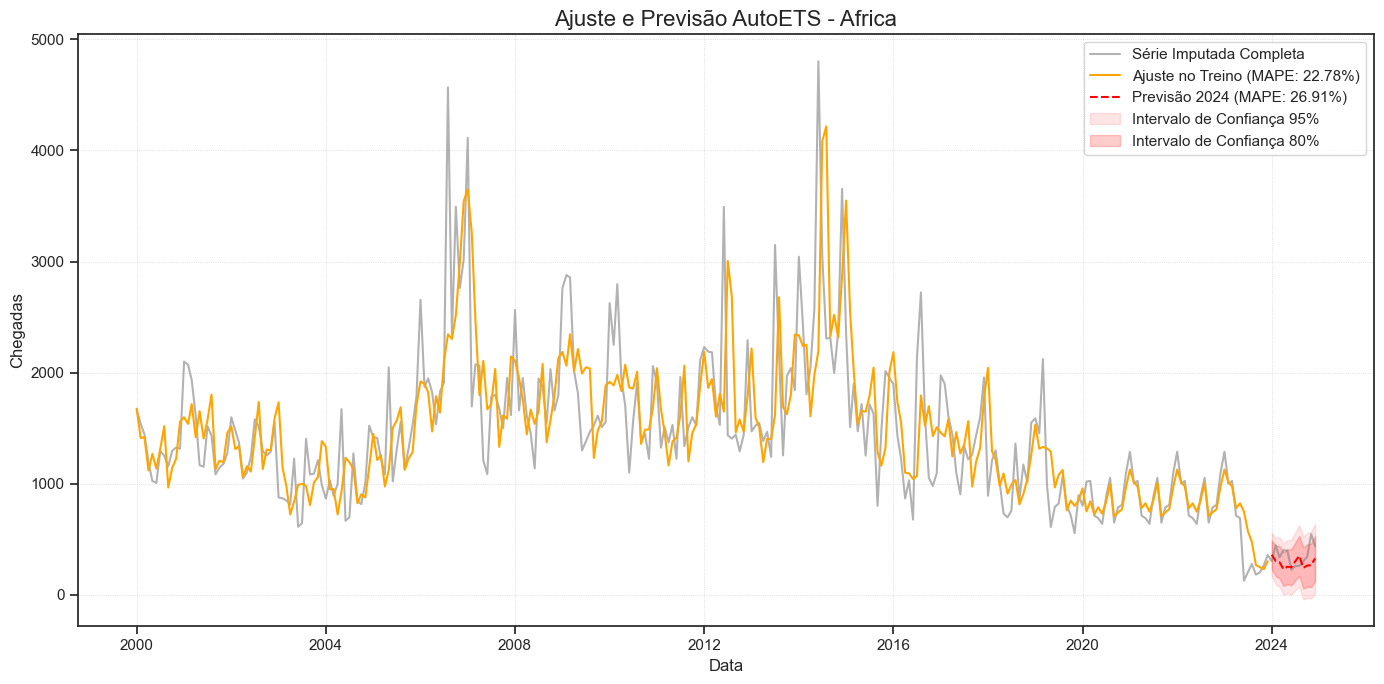


--- AMERICA_CENTRAL_E_CARIBE ---
Modelo Selecionado:  ETS(M,A,M)
RMSE (Treino): 377.77
MAPE (Treino): 31.26%
MAE (Treino): 225.35
RMSE (2024): 450.88
MAPE (2024): 26.89%
MAE (2024): 379.34


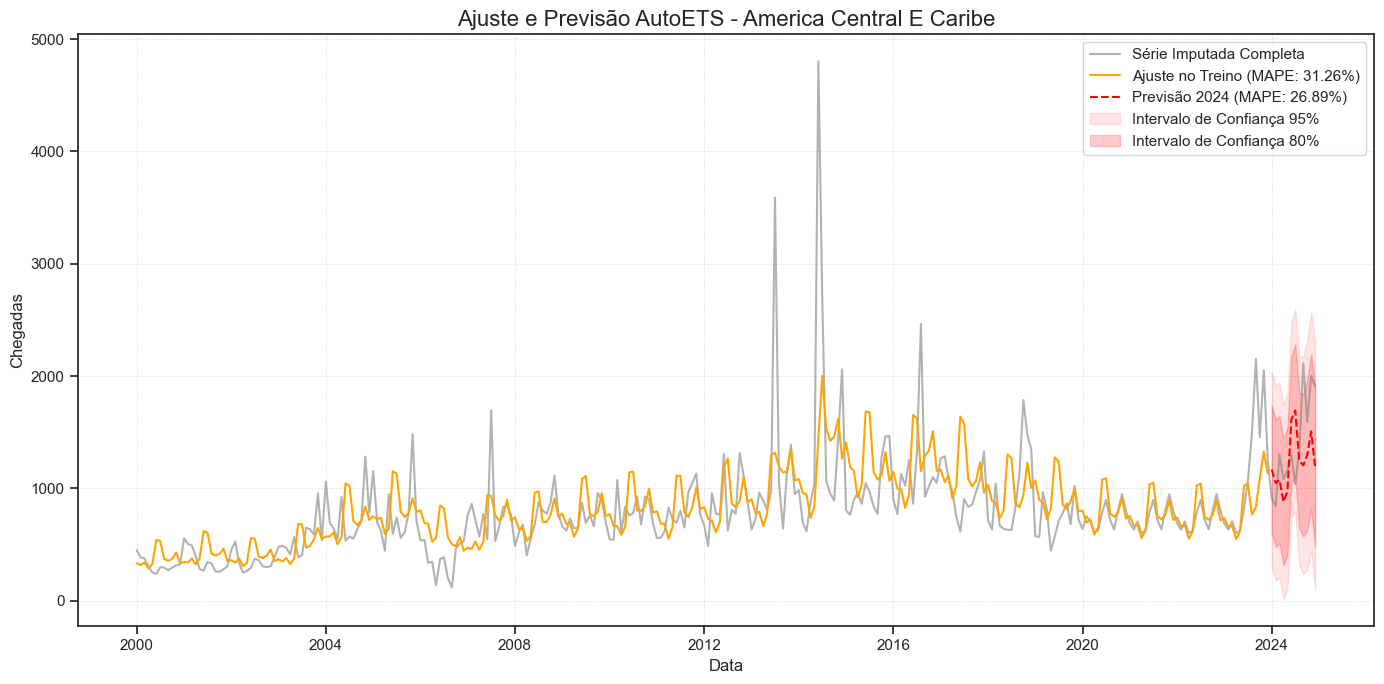


--- AMERICA_DO_NORTE ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 4735.77
MAPE (Treino): 17.52%
MAE (Treino): 2720.35
RMSE (2024): 6161.04
MAPE (2024): 24.87%
MAE (2024): 5015.30


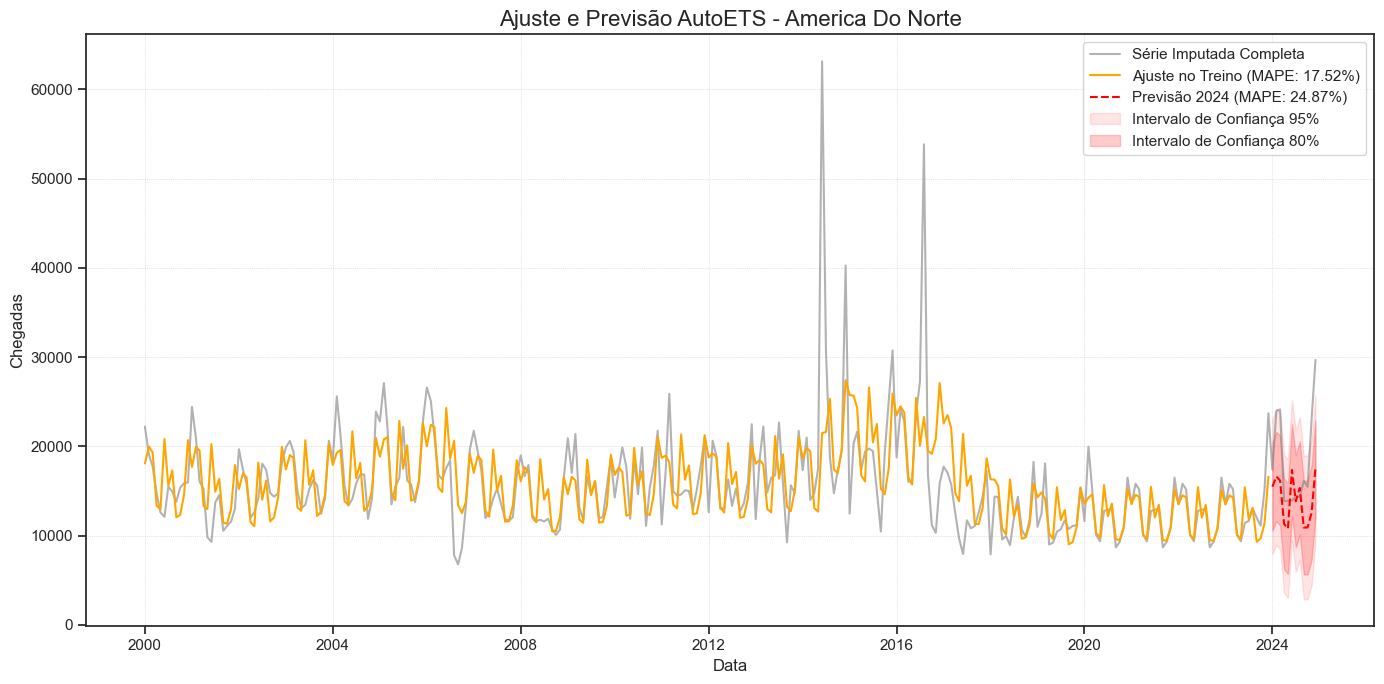


--- AMERICA_DO_SUL ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 6242.70
MAPE (Treino): 13.95%
MAE (Treino): 4154.89
RMSE (2024): 16910.41
MAPE (2024): 15.51%
MAE (2024): 13011.71


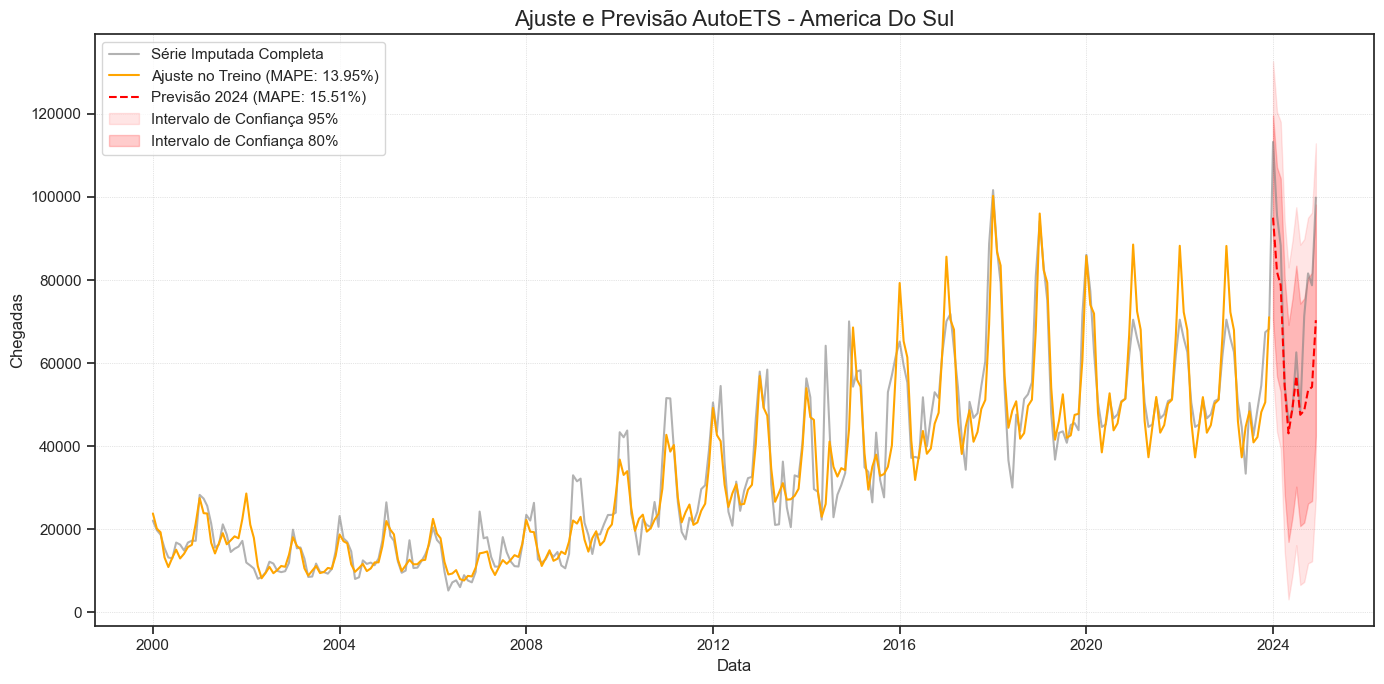


--- ASIA ---
Modelo Selecionado:  ETS(M,N,A)
RMSE (Treino): 1464.69
MAPE (Treino): 21.14%
MAE (Treino): 728.31
RMSE (2024): 1258.71
MAPE (2024): 29.18%
MAE (2024): 884.76


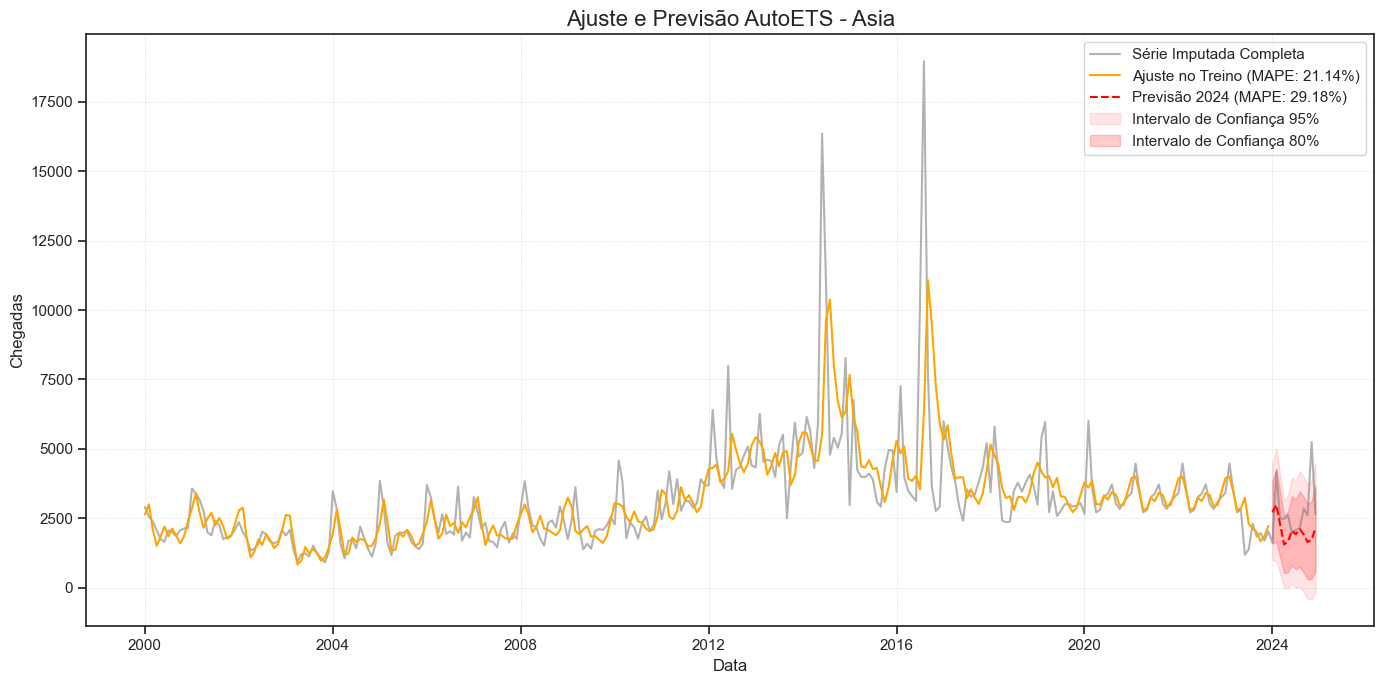


--- EUROPA ---
Modelo Selecionado:  ETS(M,N,A)
RMSE (Treino): 7046.33
MAPE (Treino): 12.81%
MAE (Treino): 4415.80
RMSE (2024): 5663.36
MAPE (2024): 16.22%
MAE (2024): 4950.67


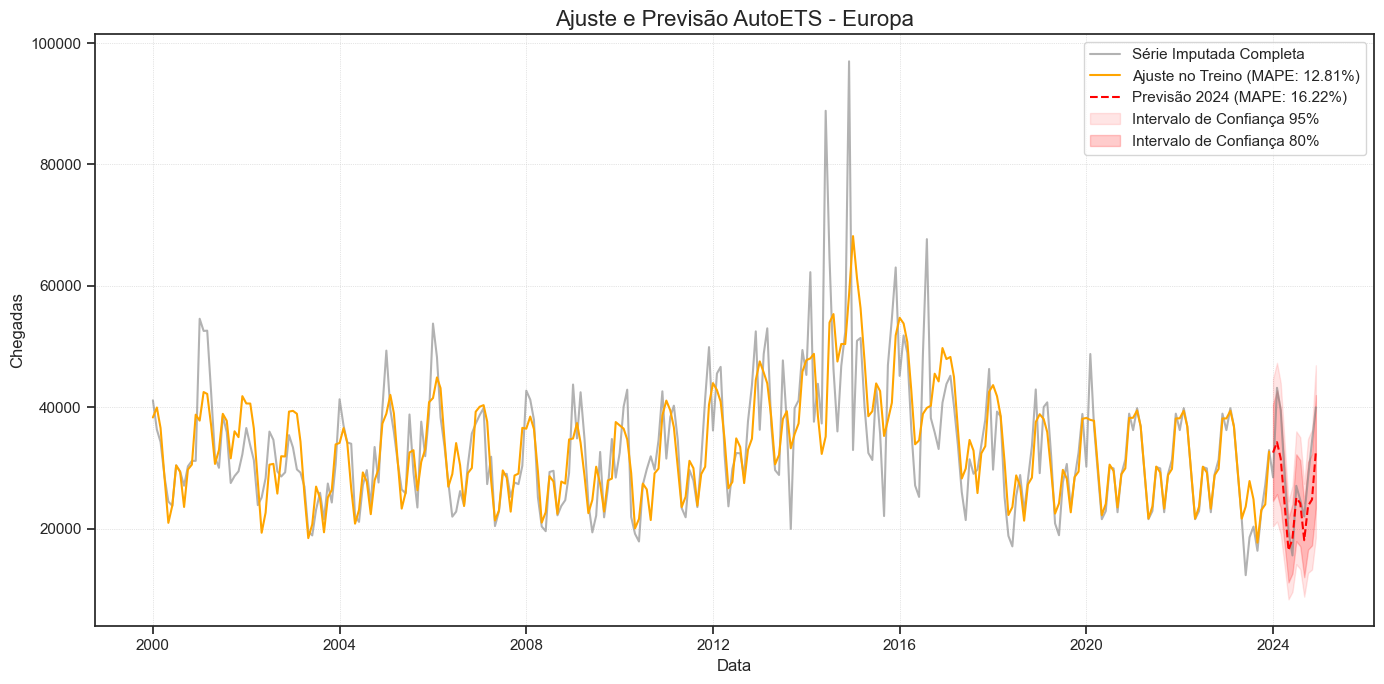


--- OCEANIA ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 677.20
MAPE (Treino): 30.10%
MAE (Treino): 353.12
RMSE (2024): 469.27
MAPE (2024): 42.24%
MAE (2024): 421.32


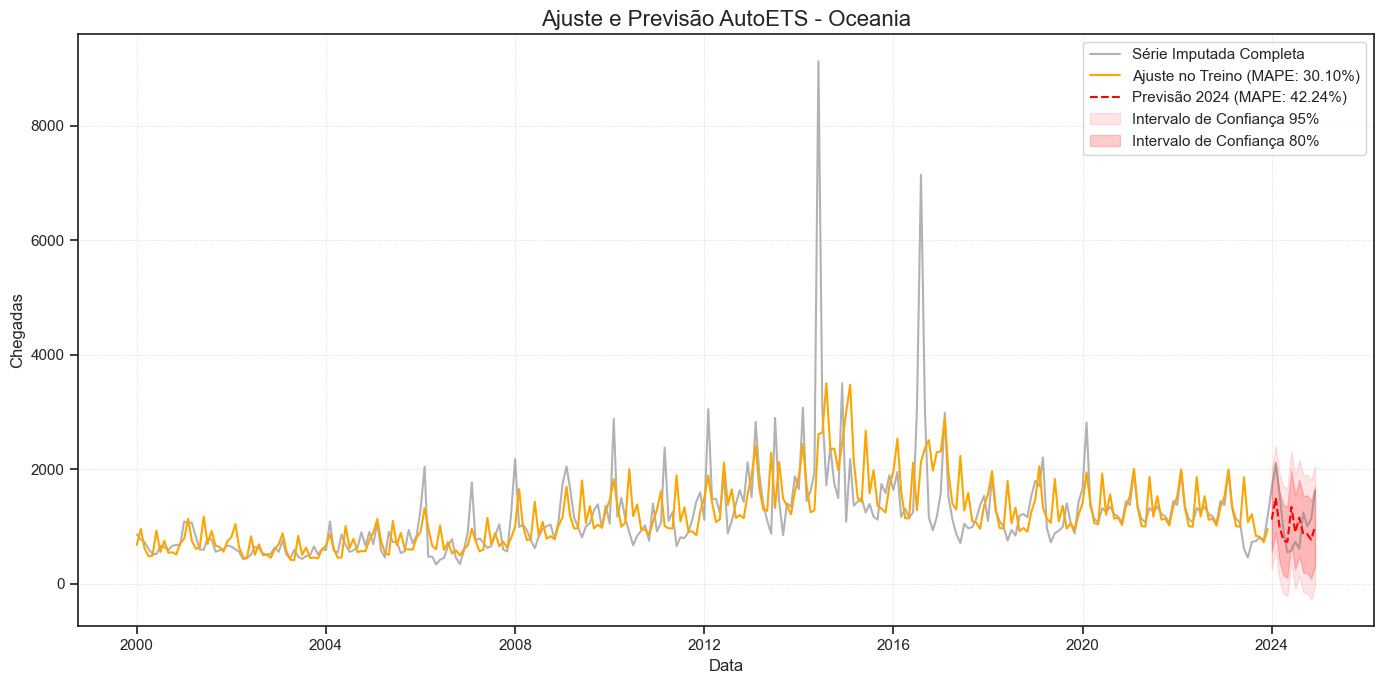

In [19]:
# Treino e teste AutoETS por continente

train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-12-31'
h = 12

for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n--- {continente.upper()} ---")
    # Dados de treino (imputados) e teste (originais) para o continente
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    test_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] >= test_start)
    ].copy()

    # Série original (não imputada) para o período de teste
    test_series = series_por_continente[continente].loc[test_start:test_end]
    y_true_teste = test_series.values

    # Treina modelo
    sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
    sf.fit(df=train_df)

    # Previsão para horizonte de teste
    forecasts = sf.forecast(df=train_df, h=h, level=[80,95], fitted=True)
    pred_index = pd.to_datetime(forecasts['ds'])
    y_pred_teste = forecasts['AutoETS'].values

    # Métricas teste
    rmse_val = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste))
    mape_val = mean_absolute_percentage_error(y_true_teste, y_pred_teste) * 100
    mae_val = mean_absolute_error(y_true_teste, y_pred_teste)

    # Ajuste no treino
    fitted_values_df = sf.forecast_fitted_values()
    y_true_treino = train_df['y'].values
    y_pred_treino = fitted_values_df['AutoETS'].values

    rmse_treino = np.sqrt(mean_squared_error(y_true_treino, y_pred_treino))
    mape_treino = mean_absolute_percentage_error(y_true_treino, y_pred_treino) * 100
    mae_treino = mean_absolute_error(y_true_treino, y_pred_treino)

    print("Modelo Selecionado: ", sf.fitted_[0][0].model_['method'])
    print(f"RMSE (Treino): {rmse_treino:.2f}")
    print(f"MAPE (Treino): {mape_treino:.2f}%")
    print(f"MAE (Treino): {mae_treino:.2f}")
    print(f"RMSE (2024): {rmse_val:.2f}")
    print(f"MAPE (2024): {mape_val:.2f}%")
    print(f"MAE (2024): {mae_val:.2f}")

    # Plot
    plt.figure(figsize=(14, 7))
    # Série histórica imputada
    plt.plot(imputed_continent_series[continente].index, imputed_continent_series[continente].values,
             label='Série Imputada Completa', color='gray', alpha=0.6)
    # Ajuste no treino
    plt.plot(fitted_values_df['ds'], y_pred_treino,
             label=f'Ajuste no Treino (MAPE: {mape_treino:.2f}%)', color='orange')
    # Previsão teste
    plt.plot(pred_index, y_pred_teste,
             label=f'Previsão 2024 (MAPE: {mape_val:.2f}%)', color='red', linestyle='--')

    # Intervalos de confiança
    plt.fill_between(pred_index, forecasts['AutoETS-lo-95'], forecasts['AutoETS-hi-95'],
                     color='red', alpha=0.1, label='Intervalo de Confiança 95%')
    plt.fill_between(pred_index, forecasts['AutoETS-lo-80'], forecasts['AutoETS-hi-80'],
                     color='red', alpha=0.2, label='Intervalo de Confiança 80%')
    plt.title(f'Ajuste e Previsão AutoETS - {continente.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Chegadas')
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()
# ...existing code...

In [20]:
print("\n--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos POR CONTINENTE ---")

error_options = ['A', 'M']
trend_options = ['N', 'A', 'M']
seasonal_options = ['N', 'A', 'M']
damped_options = [False, True]
h = 12

# Para cada continente
for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n>>> {continente.upper()} <<<")
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    test_series = series_por_continente[continente].loc[test_start:test_end]
    all_model_results = []

    for error in error_options:
        for trend in trend_options:
            for seasonal in seasonal_options:
                damped_iterable = damped_options if trend in ['A', 'M'] else [False]
                for damped in damped_iterable:
                    model_str = f"{error}{trend}{seasonal}"
                    model_name = f"ETS({model_str}, damped={damped})"
                    try:
                        sf_model = StatsForecast(
                            models=[AutoETS(season_length=12, model=model_str, damped=damped)],
                            freq='MS',
                            n_jobs=1
                        )
                        sf_model.fit(df=train_df)
                        forecast_df = sf_model.forecast(df=train_df, h=h, fitted=True)
                        y_pred_test = forecast_df['AutoETS'].values

                        if len(y_pred_test) == len(test_series.values):
                            mape_test = mean_absolute_percentage_error(test_series.values, y_pred_test) * 100
                            rmse_test = np.sqrt(mean_squared_error(test_series.values, y_pred_test))
                            mae_test = mean_absolute_error(test_series.values, y_pred_test)

                            fitted_df = sf_model.forecast_fitted_values()
                            y_pred_train = fitted_df['AutoETS'].values
                            y_true_train = train_df['y'].values

                            mape_train = mean_absolute_percentage_error(y_true_train, y_pred_train) * 100
                            rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
                            mae_train = mean_absolute_error(y_true_train, y_pred_train)

                            residuals = y_true_train - y_pred_train

                            _, t_pvalue = ttest_1samp(residuals, 0)
                            lb_df = acorr_ljungbox(residuals, lags=[24], return_df=True)
                            lb_pvalue = lb_df['lb_pvalue'].iloc[0]
                            _, jb_pvalue = stats.jarque_bera(residuals)
                            arch_test = het_arch(residuals, nlags=12)
                            arch_pvalue = arch_test[1]

                            all_model_results.append({
                                'continent': continente,
                                'model': model_name,
                                'mape_test': mape_test,
                                'rmse_test': rmse_test,
                                'mae_test': mae_test,
                                'mape_train': mape_train,
                                'rmse_train': rmse_train,
                                'mae_train': mae_train,
                                't_test_pvalue': t_pvalue,
                                'ljung_box_pvalue': lb_pvalue,
                                'jarque_bera_pvalue': jb_pvalue,
                                'arch_pvalue': arch_pvalue
                            })
                        else:
                            all_model_results.append({'continent': continente, 'model': model_name, 'mape_test': float('inf')})
                    except Exception as e:
                        all_model_results.append({'continent': continente, 'model': model_name, 'mape_test': float('inf')})

    results_summary_df = pd.DataFrame(all_model_results)
    # Remove as linhas onde o modelo falhou (mape_test é infinito)
    results_summary_df = results_summary_df[results_summary_df['mape_test'] != float('inf')]
    print(results_summary_df.sort_values(by='rmse_test').reset_index(drop=True))


--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos POR CONTINENTE ---

>>> AFRICA <<<
   continent                   model  mape_test   rmse_test    mae_test  \
0     africa  ETS(MAN, damped=False)  20.556707   97.010548   76.897935   
1     africa  ETS(MMN, damped=False)  20.621248  103.611581   79.898057   
2     africa  ETS(ANN, damped=False)  20.490070  103.716039   79.487424   
3     africa   ETS(AAN, damped=True)  20.493843  103.908444   79.578589   
4     africa  ETS(MNN, damped=False)  20.781719  105.579484   81.115442   
5     africa   ETS(MMN, damped=True)  20.837483  105.892608   81.406267   
6     africa   ETS(MAN, damped=True)  20.843169  105.938649   81.441767   
7     africa   ETS(MMM, damped=True)  27.975969  112.168205   96.432995   
8     africa  ETS(MMM, damped=False)  27.523703  112.893517   96.652981   
9     africa   ETS(MAM, damped=True)  25.879311  113.251020   95.279010   
10    africa  ETS(MAM, damped=False)  28.950525  123.309955  105.756444   
1


--- Análise de Resíduos do Modelo AutoETS por Continente ---

==================== Africa ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.8223
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0675
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.3605
   ✓ PASSA: Não há evidência de heterocedasticidade.


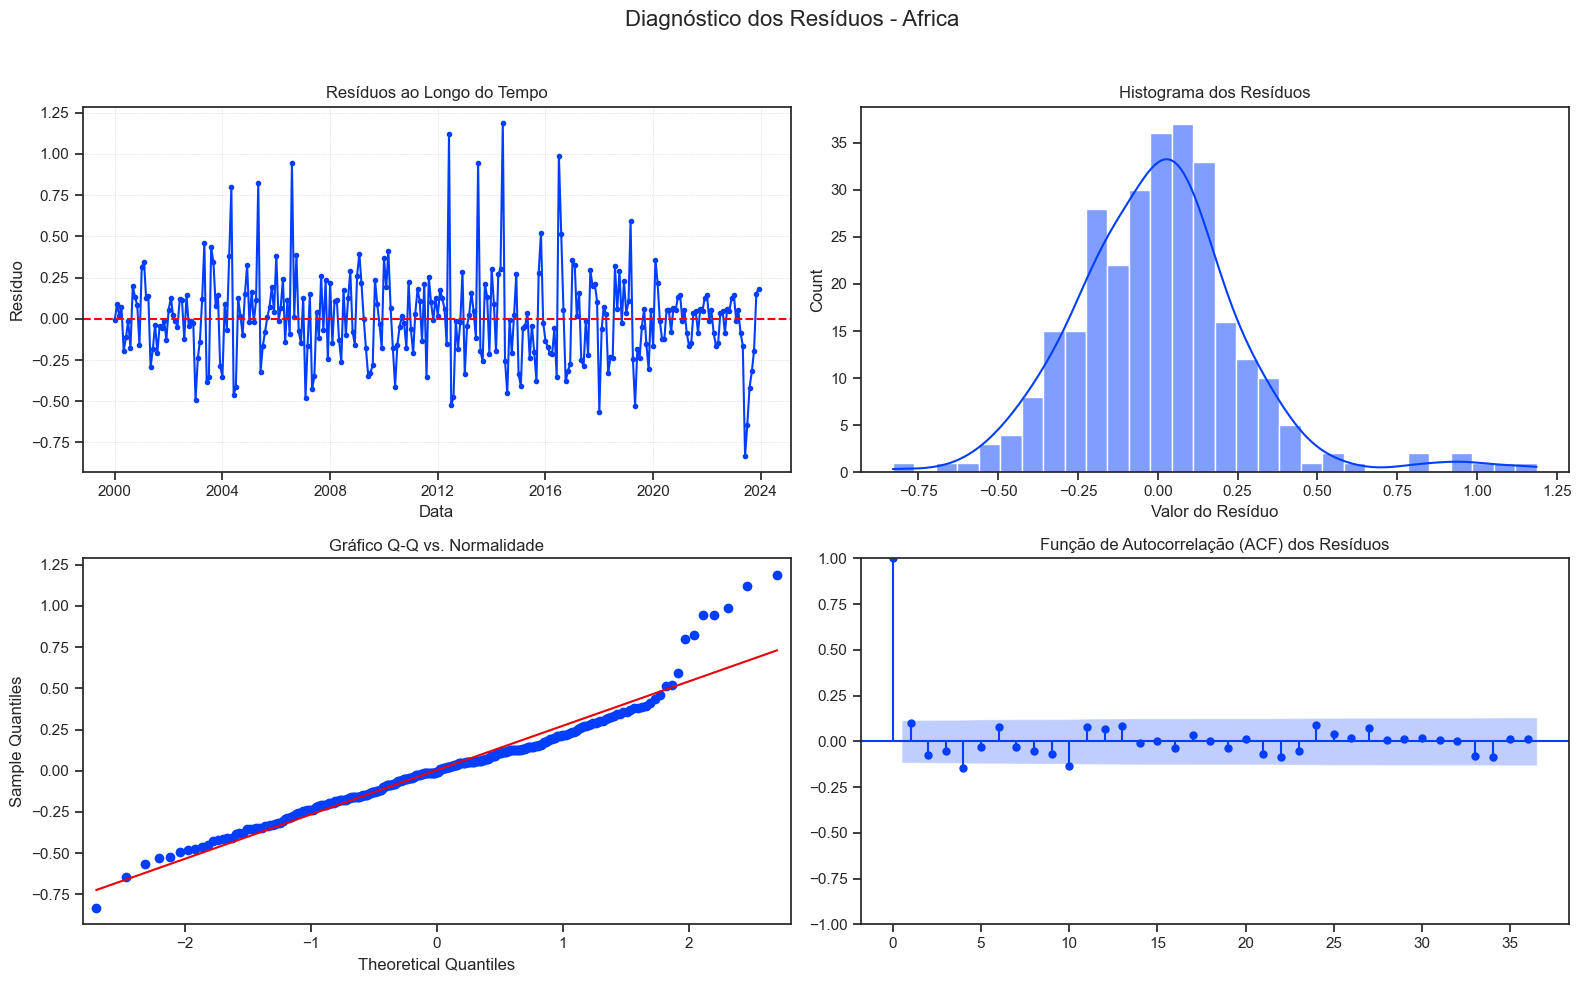


==================== America Central E Caribe ====================
Modelo Selecionado: ETS(M,A,M)

1. Teste T para Média Zero:
   p-valor: 0.4890
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0000
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0026
   ✗ FALHA: Heterocedasticidade detectada.


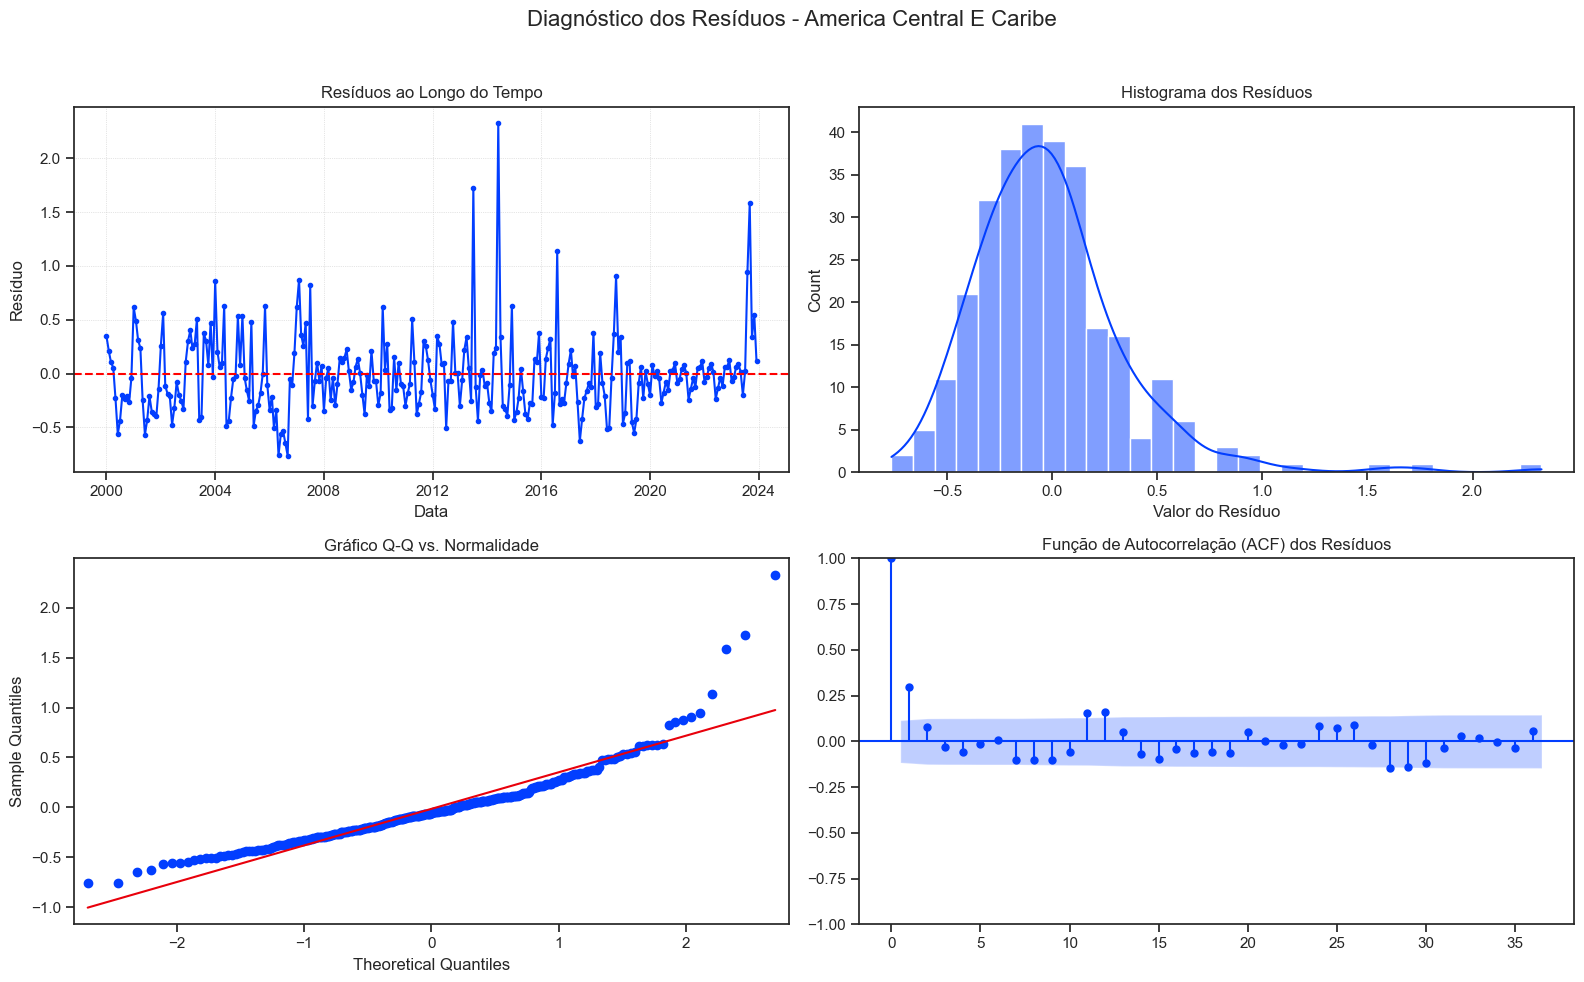


==================== America Do Norte ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.9894
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0049
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.9975
   ✓ PASSA: Não há evidência de heterocedasticidade.


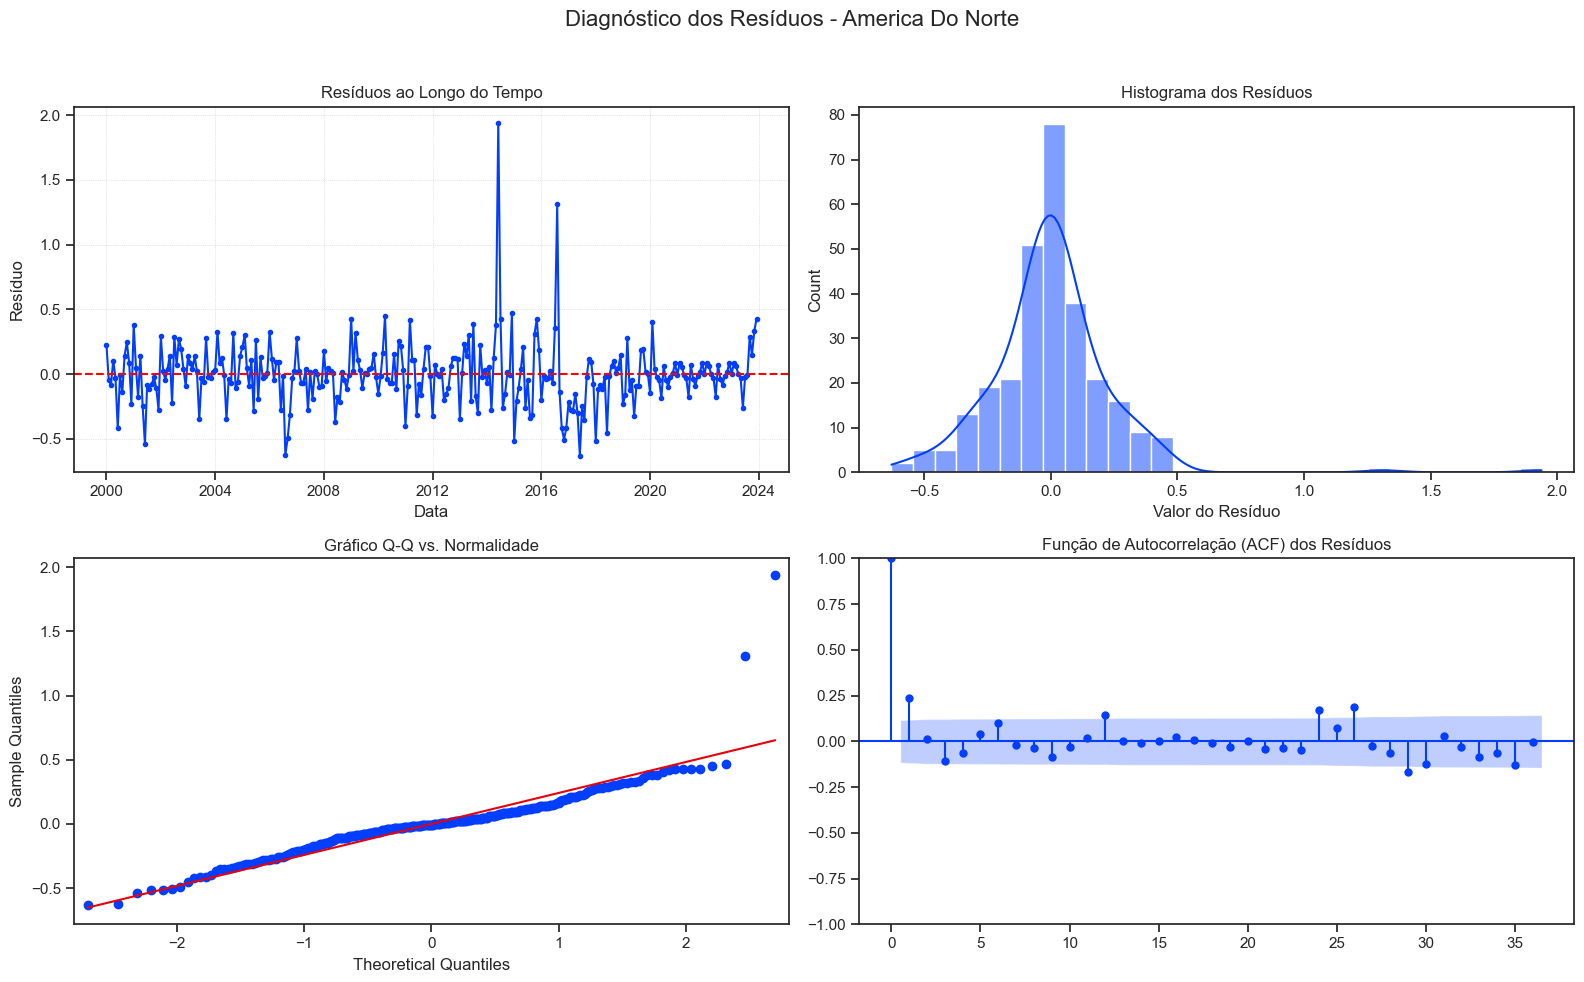


==================== America Do Sul ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.0387
   ✗ FALHA: A média dos resíduos é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0002
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.9369
   ✓ PASSA: Não há evidência de heterocedasticidade.


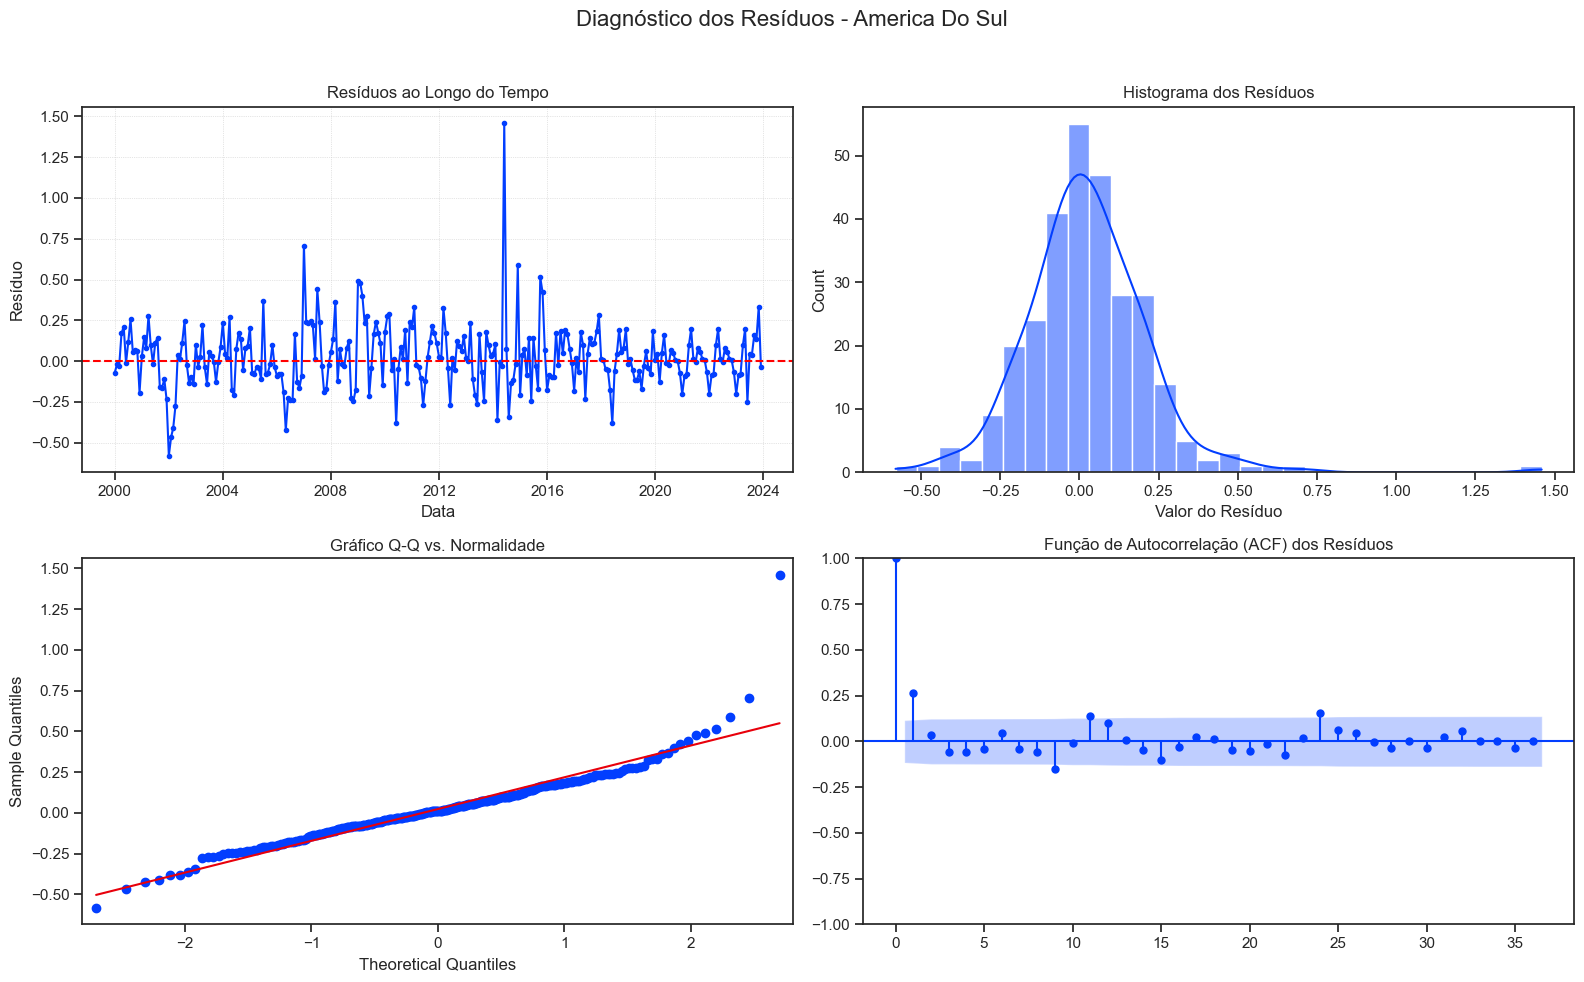


==================== Asia ====================
Modelo Selecionado: ETS(M,N,A)

1. Teste T para Média Zero:
   p-valor: 0.3208
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0000
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0085
   ✗ FALHA: Heterocedasticidade detectada.


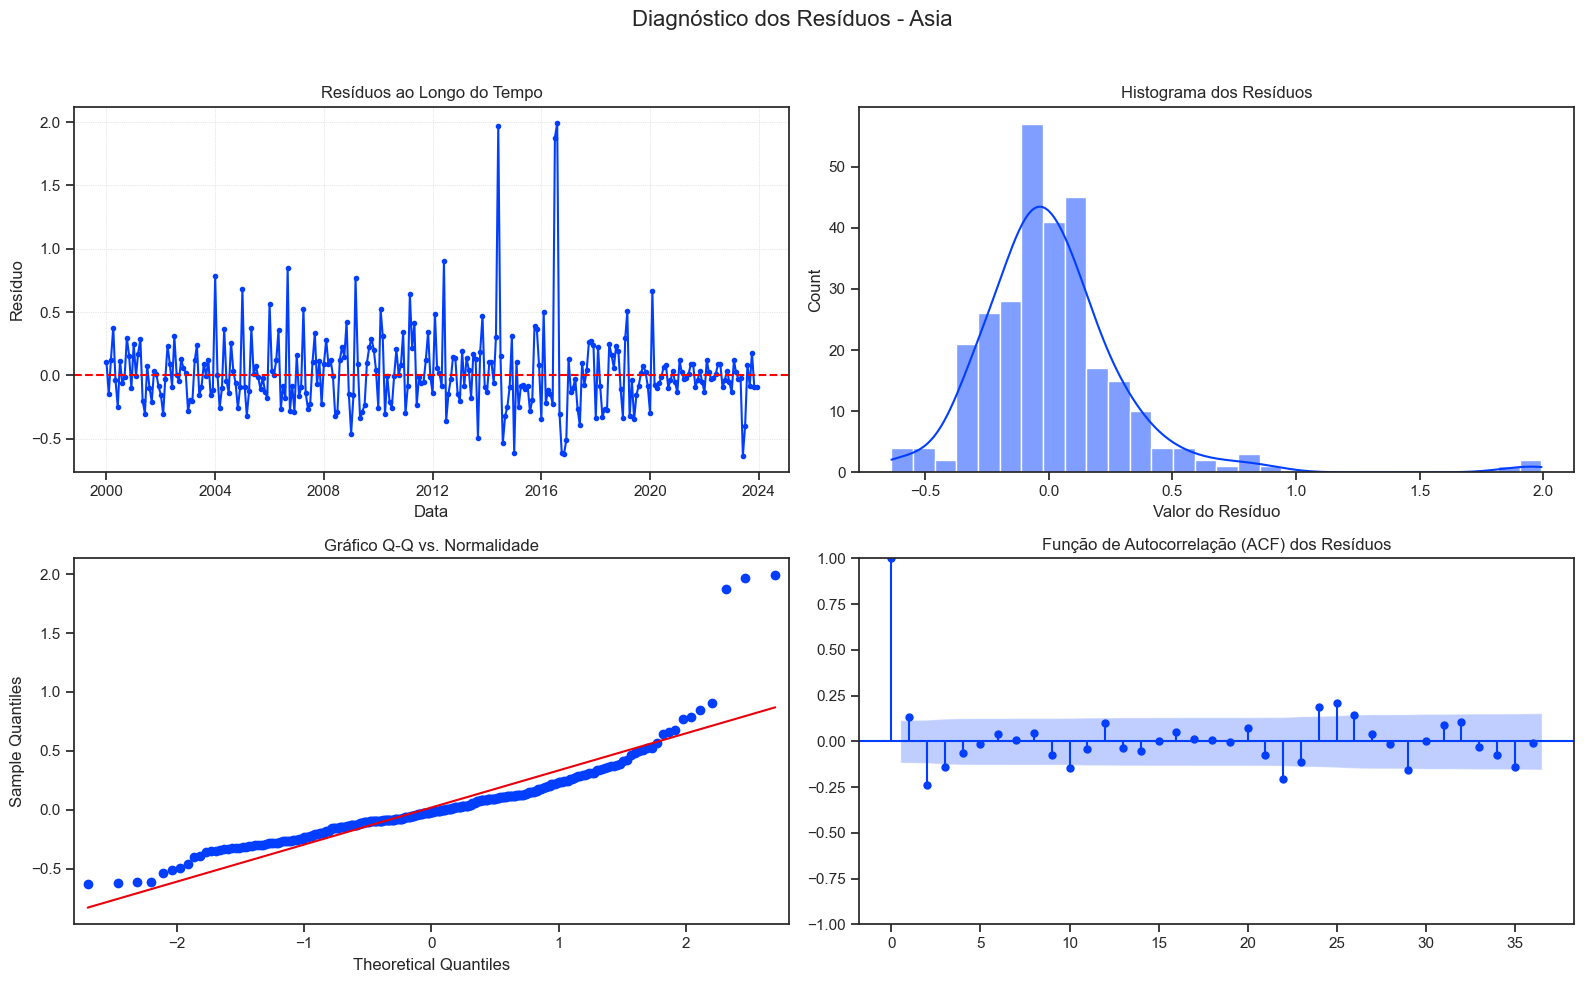


==================== Europa ====================
Modelo Selecionado: ETS(M,N,A)

1. Teste T para Média Zero:
   p-valor: 0.9782
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0009
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.7139
   ✓ PASSA: Não há evidência de heterocedasticidade.


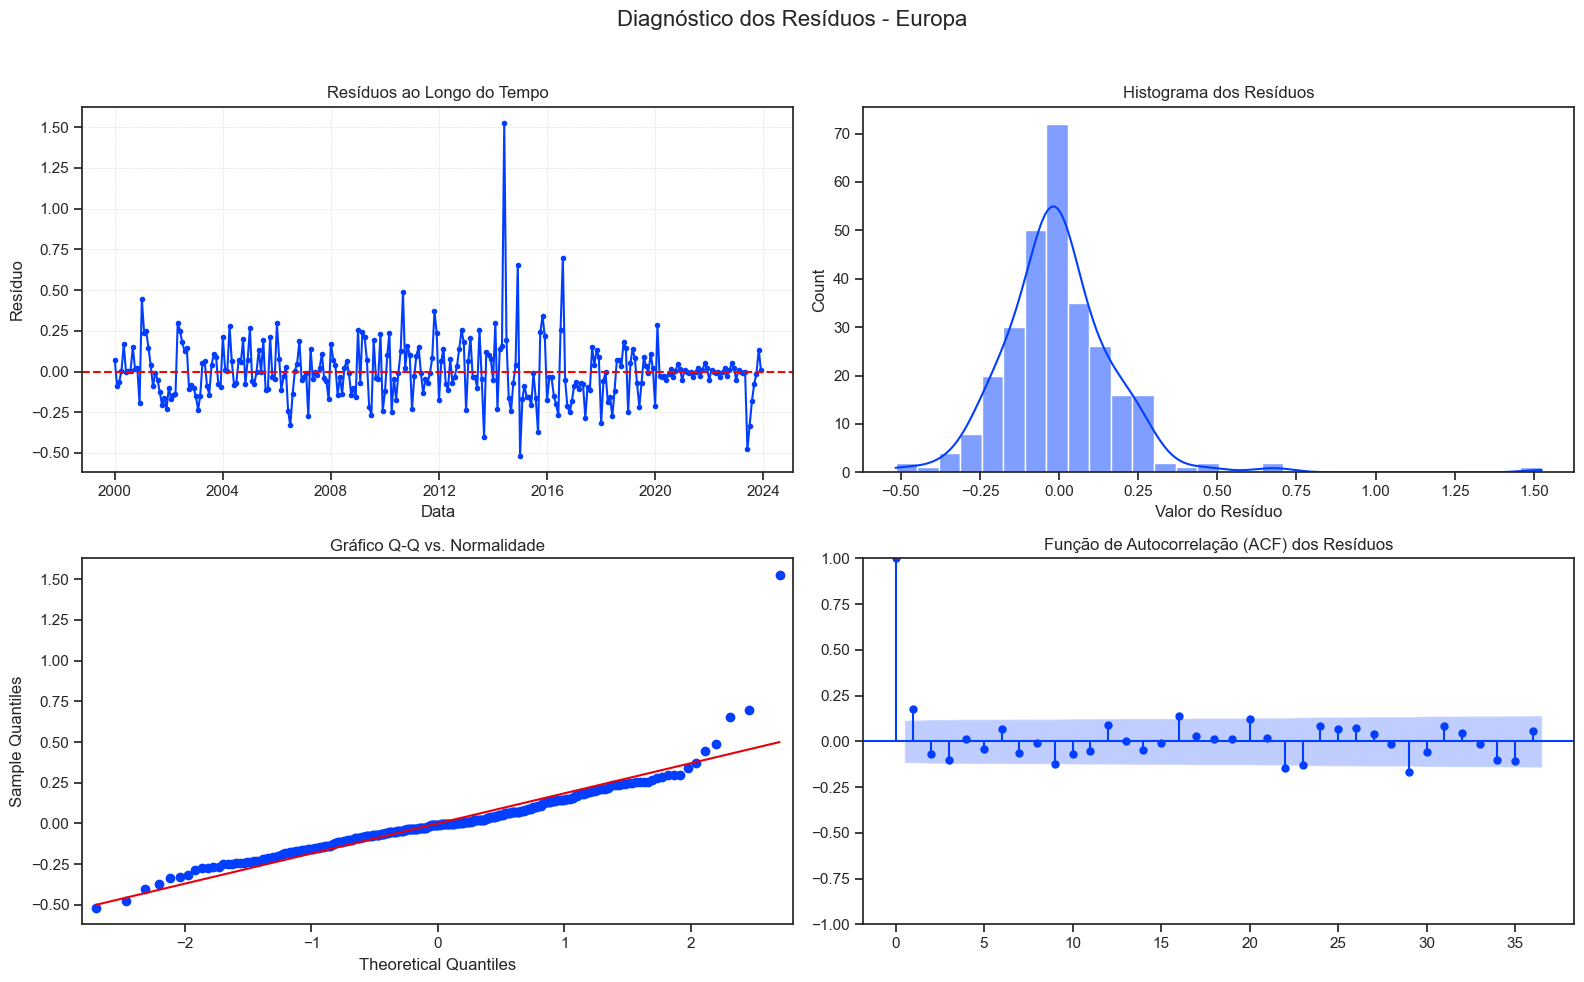


==================== Oceania ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.3239
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0316
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.7871
   ✓ PASSA: Não há evidência de heterocedasticidade.


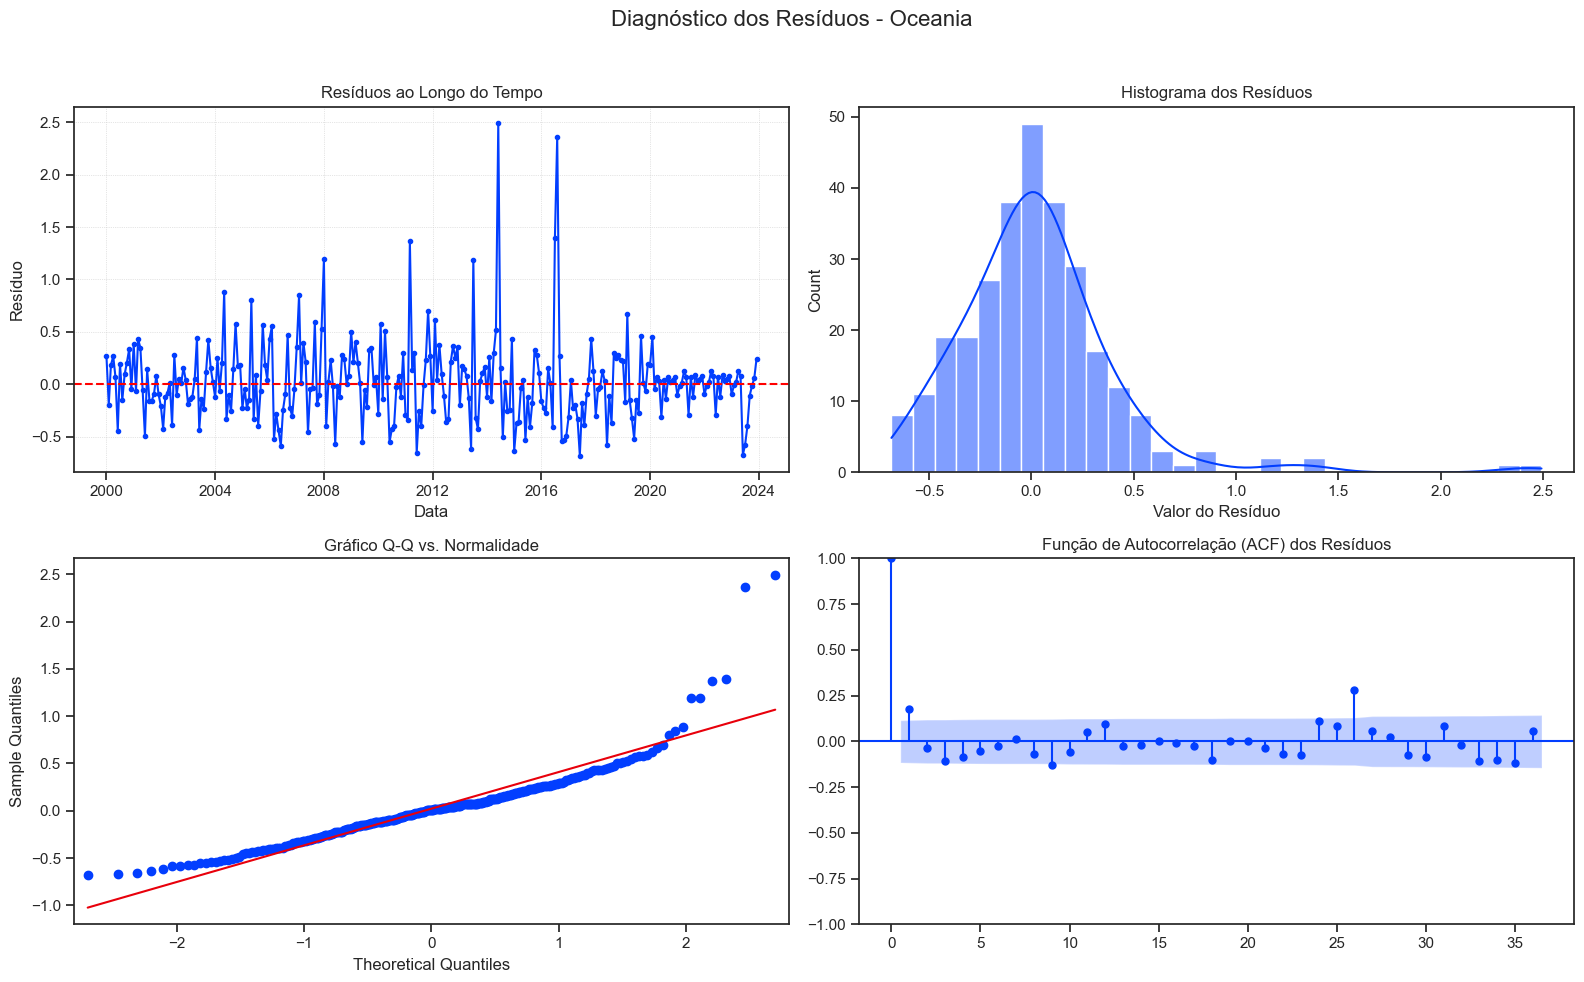

In [21]:
print("\n--- Análise de Resíduos do Modelo AutoETS por Continente ---")

# Definir os períodos de treino e teste
train_end = '2023-12-31'
test_start = '2024-01-01'

# Itera sobre cada continente para treinar um modelo e analisar seus resíduos
for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n{'='*20} {continente.replace('_', ' ').title()} {'='*20}")

    # Filtra os dados de treino para o continente atual
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()

    # Inicializa e treina o modelo AutoETS
    sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
    sf.fit(df=train_df)
    sf.forecast(df=train_df, h=12, fitted=True)

    # Extrai os resíduos do modelo no período de treino
    # Resíduos = Valores Reais - Valores Ajustados (Fitted)
    y_true_treino = train_df['y'].values
    fitted_values_df = sf.forecast_fitted_values()
    y_pred_treino = fitted_values_df['AutoETS'].values

    print(f"Modelo Selecionado: {sf.fitted_[0][0].model_['method']}")
    
    # --- Testes Estatísticos nos Resíduos ---
    
    # 1. Teste T para Média Zero
    print("\n1. Teste T para Média Zero:")
    if len(sf.fitted_[0][0].model_['residuals']) > 1:
        t_stat, t_pvalue = ttest_1samp(sf.fitted_[0][0].model_['residuals'], 0)
        print(f"   p-valor: {t_pvalue:.4f}")
        if t_pvalue > 0.05:
            print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.")
        else:
            print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero.")
    else:
        print("   Não foi possível realizar o Teste T.")

    # 2. Teste de Ljung-Box para Autocorrelação
    print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
    if len(sf.fitted_[0][0].model_['residuals']) > 24:
        lb_test = acorr_ljungbox(sf.fitted_[0][0].model_['residuals'], lags=[24], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0]
        print(f"   p-valor: {lb_pvalue:.4f}")
        if lb_pvalue > 0.05:
            print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.")
        else:
            print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.")
    else:
        print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

    # 3. Teste de Jarque-Bera para Normalidade
    print("\n3. Teste de Jarque-Bera (Normalidade):")
    if len(sf.fitted_[0][0].model_['residuals']) > 1:
        jb_stat, jb_pvalue = stats.jarque_bera(sf.fitted_[0][0].model_['residuals'])
        print(f"   p-valor: {jb_pvalue:.4f}")
        if jb_pvalue > 0.05:
            print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos.")
        else:
            print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.")
    else:
        print("   Não foi possível realizar o Teste de Jarque-Bera.")

    # 4. Teste ARCH para Heterocedasticidade
    print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
    try:
        arch_test = het_arch(sf.fitted_[0][0].model_['residuals'], nlags=12)
        arch_pvalue = arch_test[1]
        print(f"   p-valor: {arch_pvalue:.4f}")
        if arch_pvalue > 0.05:
            print("   ✓ PASSA: Não há evidência de heterocedasticidade.")
        else:
            print("   ✗ FALHA: Heterocedasticidade detectada.")
    except Exception as e:
        print(f"   Não foi possível realizar o Teste ARCH: {e}")

    # --- Plots de Diagnóstico ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Diagnóstico dos Resíduos - {continente.replace("_", " ").title()}', fontsize=16)

    # Plot 1: Resíduos ao longo do tempo
    axes[0, 0].plot(train_df['ds'], sf.fitted_[0][0].model_['residuals'], marker='o', linestyle='-', markersize=3)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_title('Resíduos ao Longo do Tempo')
    axes[0, 0].set_xlabel('Data')
    axes[0, 0].set_ylabel('Resíduo')
    axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

    # Plot 2: Histograma dos resíduos
    sns.histplot(sf.fitted_[0][0].model_['residuals'], kde=True, ax=axes[0, 1], bins=30)
    axes[0, 1].set_title('Histograma dos Resíduos')
    axes[0, 1].set_xlabel('Valor do Resíduo')

    # Plot 3: Gráfico Q-Q (Quantil-Quantil)
    sm.qqplot(sf.fitted_[0][0].model_['residuals'], line='s', ax=axes[1, 0])
    axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

    # Plot 4: Gráfico de Autocorrelação (ACF)
    sm.graphics.tsa.plot_acf(sf.fitted_[0][0].model_['residuals'], ax=axes[1, 1], lags=36)
    axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

--- Verificando Autocorrelação nos Resíduos do AutoETS por Continente ---
✓ Africa: Sem autocorrelação significativa (p-valor=0.0675).
✗ America_Central_E_Caribe: Autocorrelação detectada (p-valor=0.0000). Adicionando ao modelo híbrido.
✗ America_Do_Norte: Autocorrelação detectada (p-valor=0.0049). Adicionando ao modelo híbrido.
✗ America_Do_Sul: Autocorrelação detectada (p-valor=0.0002). Adicionando ao modelo híbrido.
✗ Asia: Autocorrelação detectada (p-valor=0.0000). Adicionando ao modelo híbrido.
✗ Europa: Autocorrelação detectada (p-valor=0.0009). Adicionando ao modelo híbrido.
✗ Oceania: Autocorrelação detectada (p-valor=0.0316). Adicionando ao modelo híbrido.

--- Construindo Modelos Híbridos (ETS+ARIMA) ---

==================== Modelo Híbrido para: America_Central_E_Caribe ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS       -> RMSE: 450.88, MAPE: 26.89%
Híbrido (ETS+ARIMA) -> RMSE: 450.53, MAPE: 26.82%


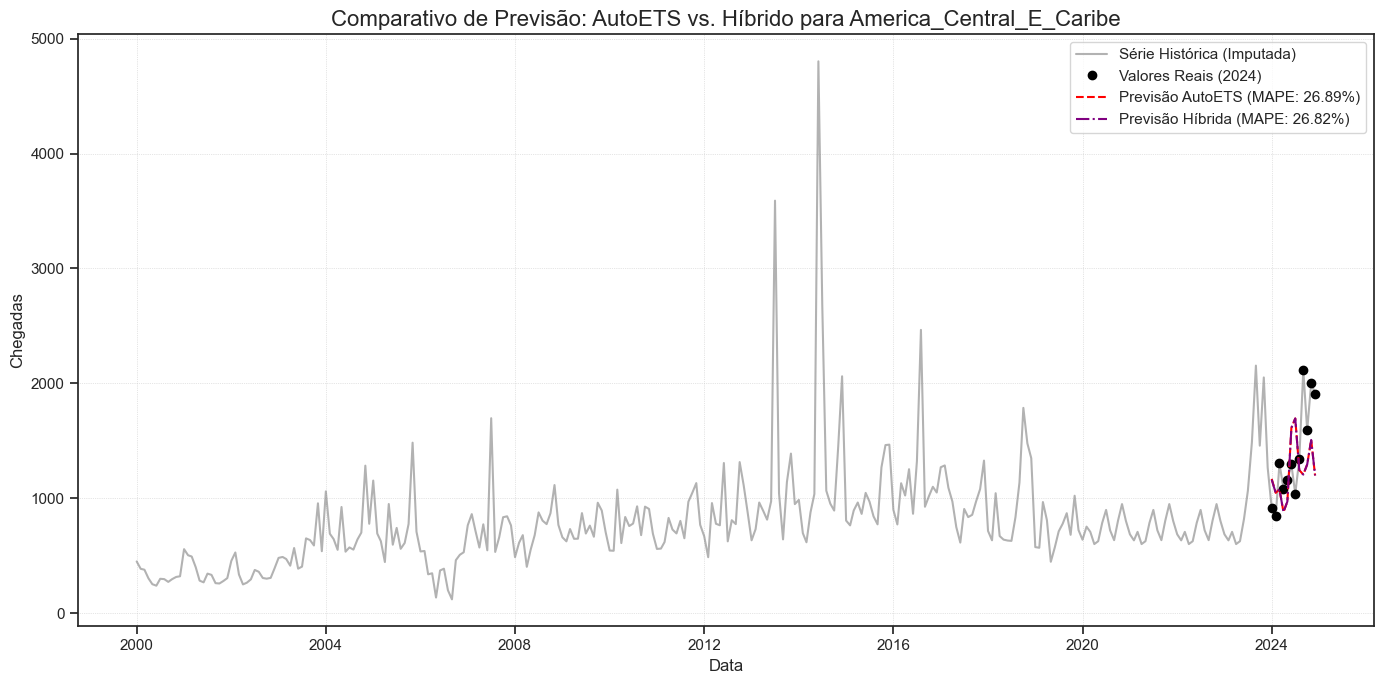


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ARIMA nos Resíduos: (0, 1, 0, 0, 1, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.3332
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0489
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0001
   ✗ FALHA: Heterocedasticidade detectada.


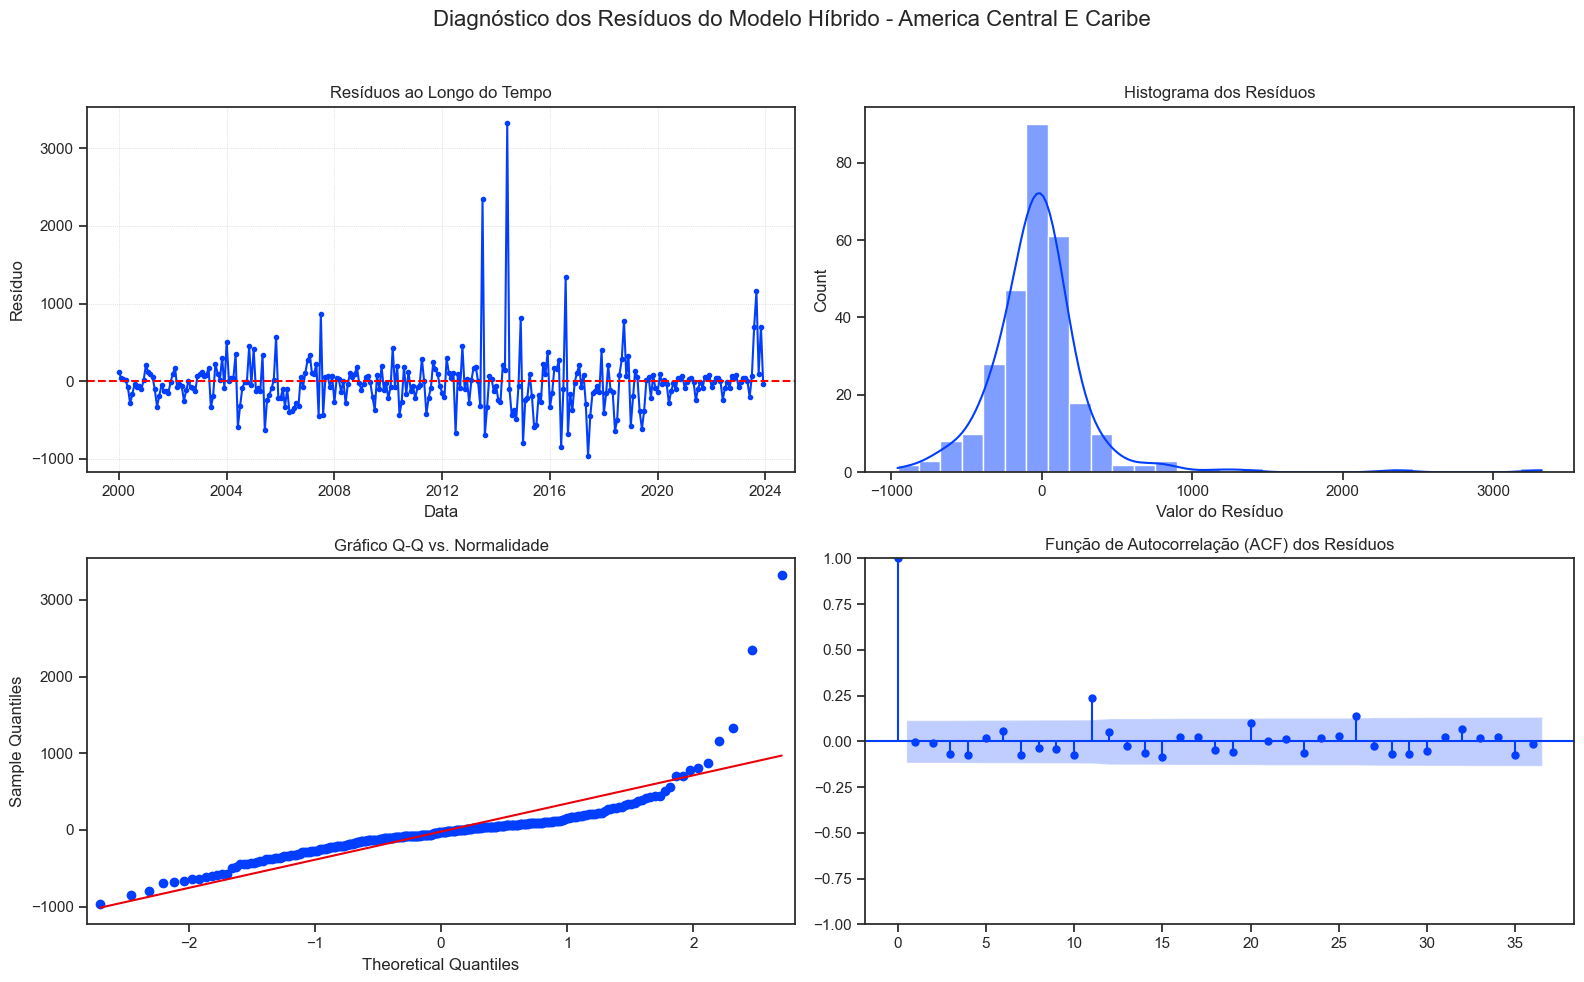


==================== Modelo Híbrido para: America_Do_Norte ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS       -> RMSE: 6161.04, MAPE: 24.87%
Híbrido (ETS+ARIMA) -> RMSE: 5831.43, MAPE: 23.15%


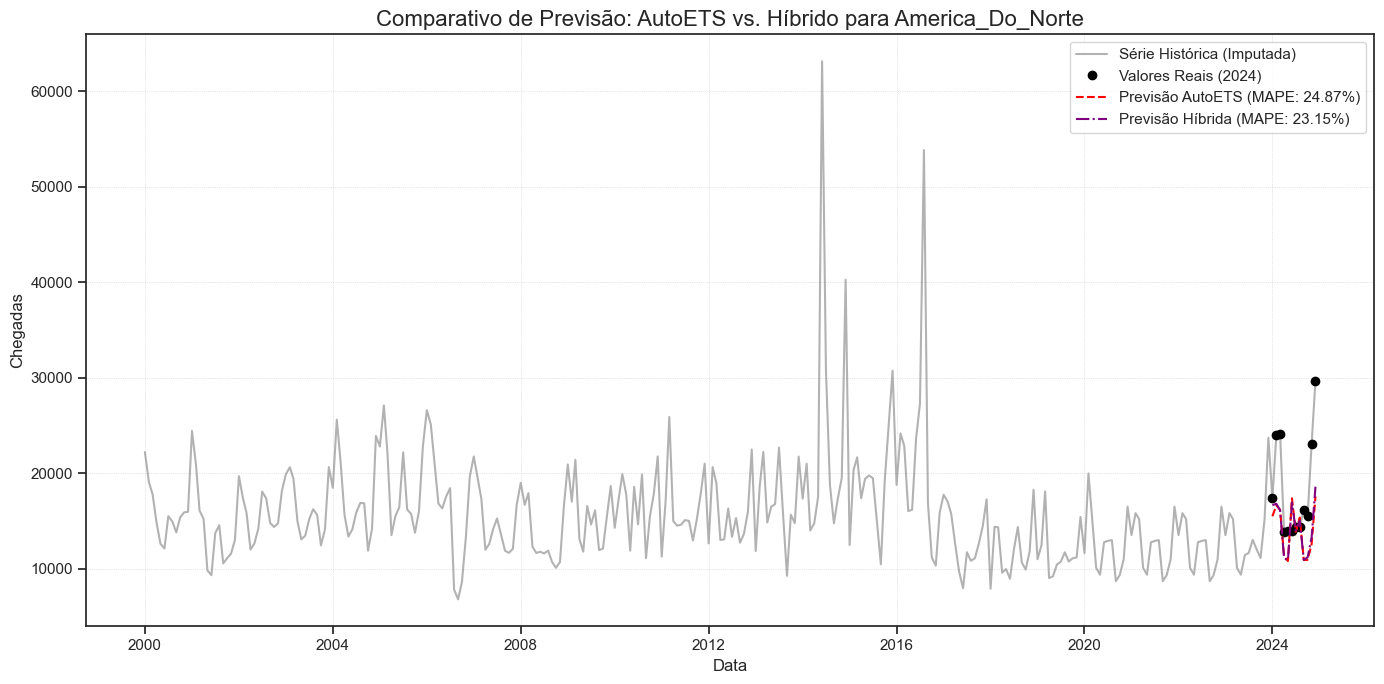


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ARIMA nos Resíduos: (2, 3, 0, 2, 12, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.7393
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.9817
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.9799
   ✓ PASSA: Não há evidência de heterocedasticidade.


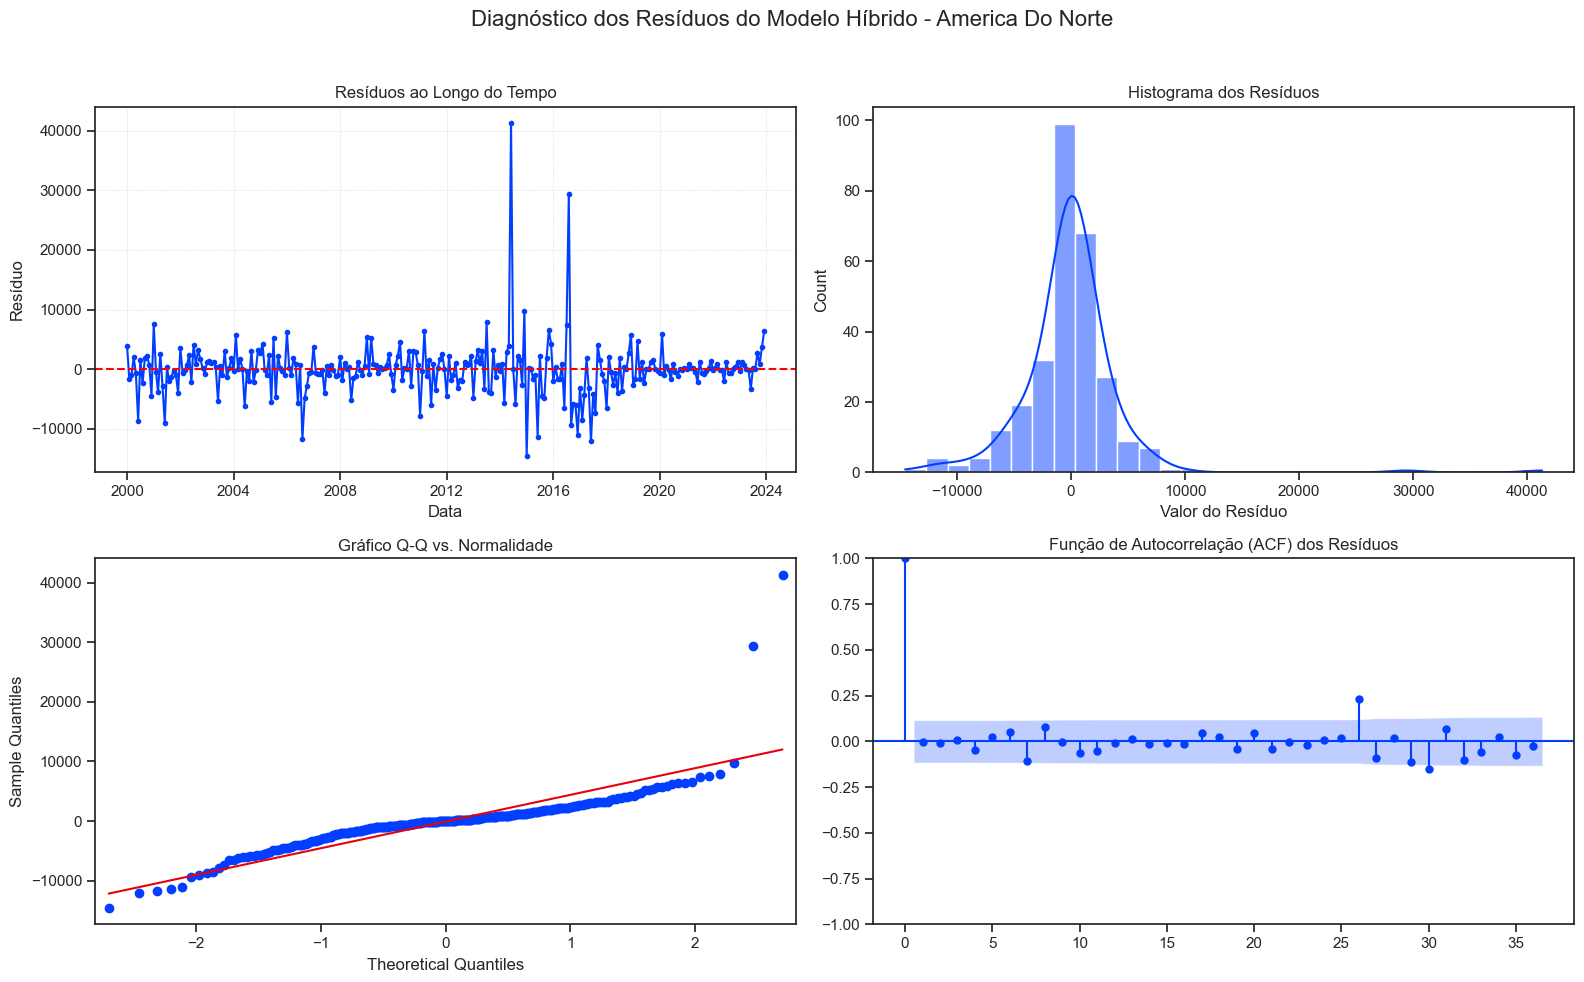


==================== Modelo Híbrido para: America_Do_Sul ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS       -> RMSE: 16910.41, MAPE: 15.51%
Híbrido (ETS+ARIMA) -> RMSE: 17860.45, MAPE: 16.13%


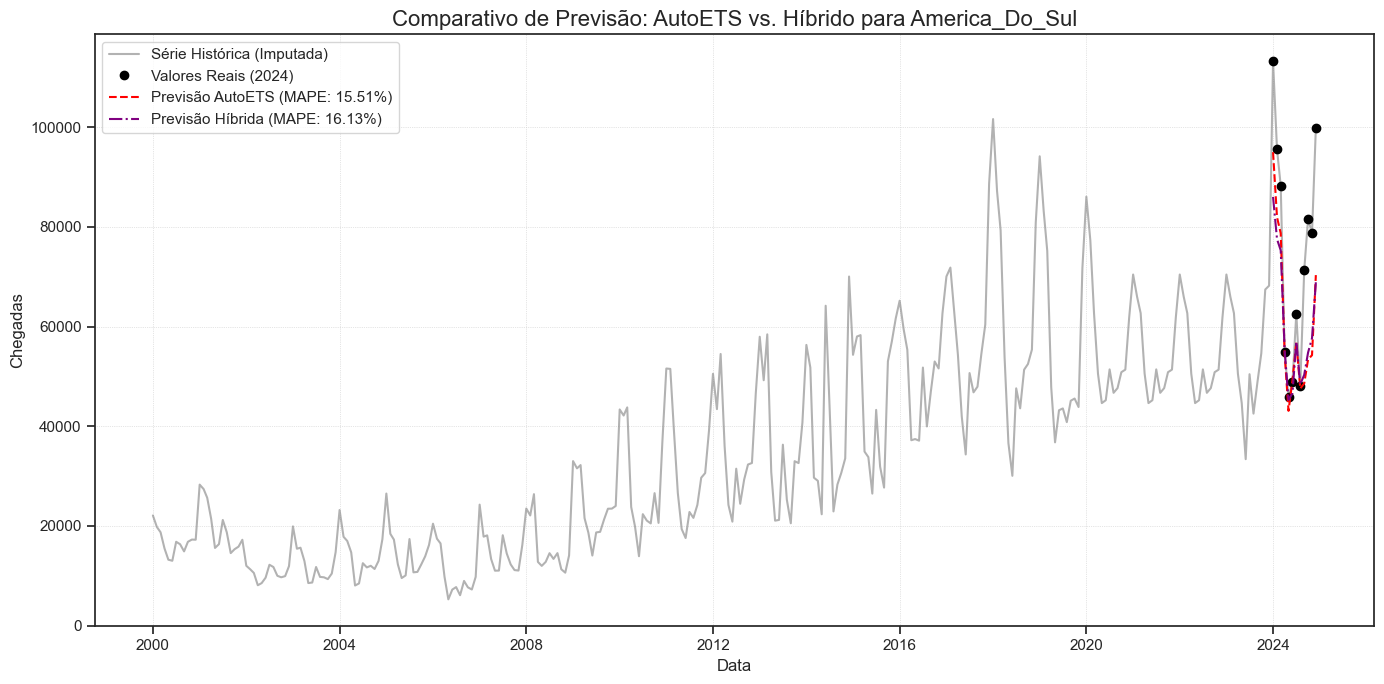


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ARIMA nos Resíduos: (2, 1, 2, 0, 12, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.2970
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0468
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0009
   ✗ FALHA: Heterocedasticidade detectada.


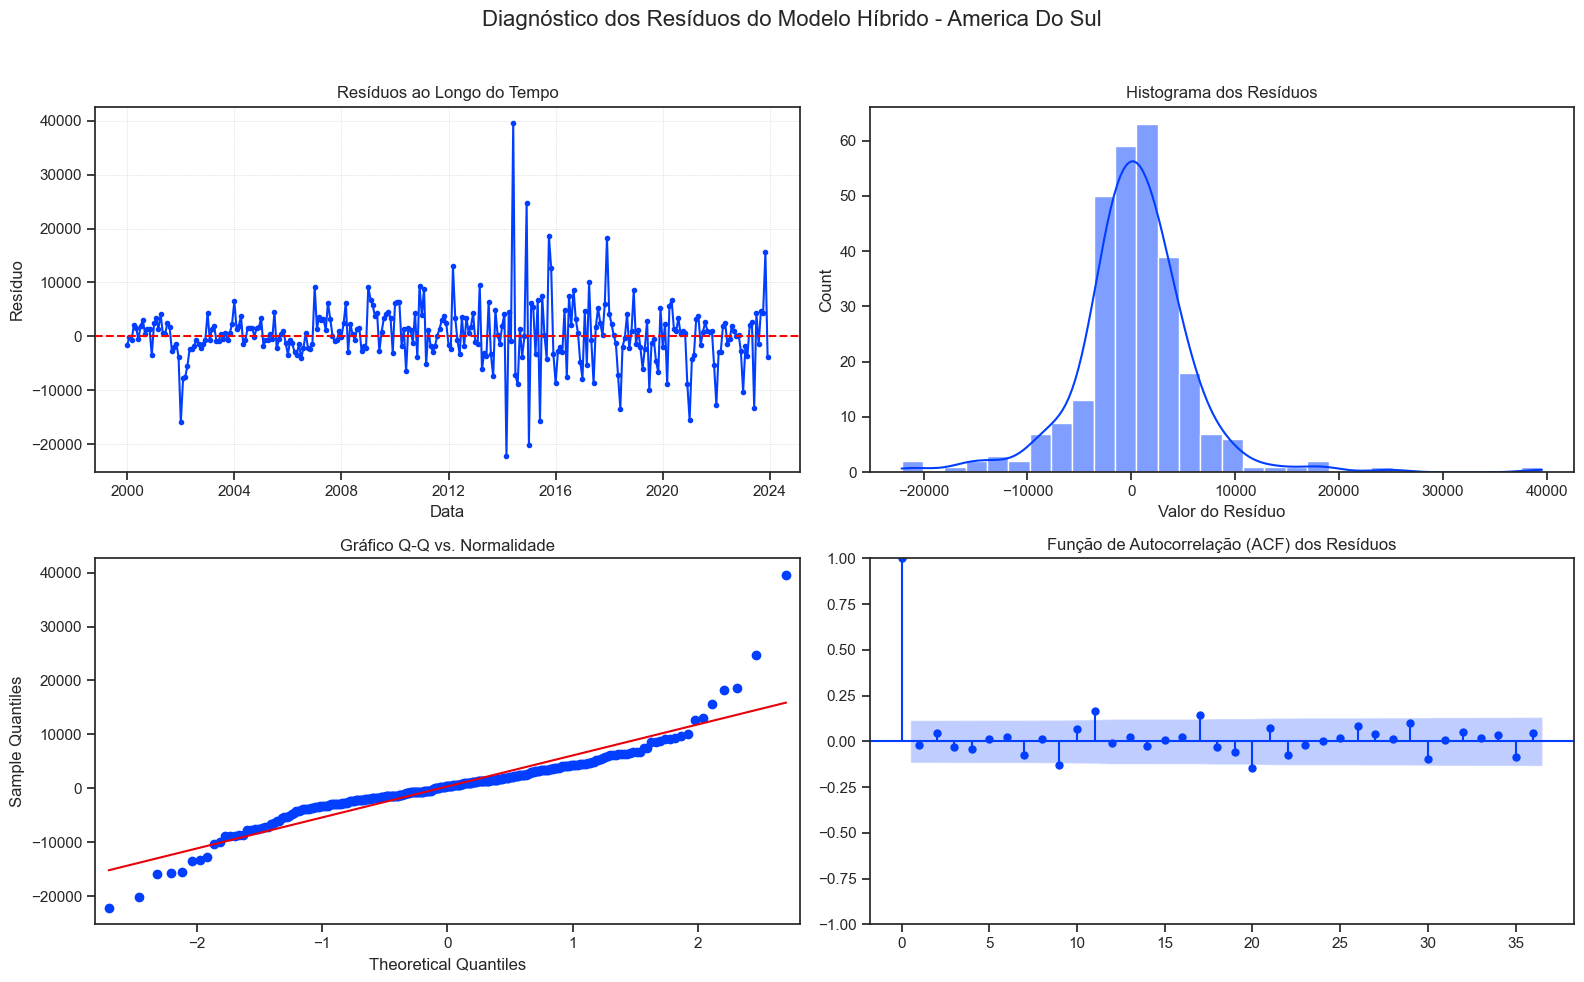


==================== Modelo Híbrido para: Asia ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS       -> RMSE: 1258.71, MAPE: 29.18%
Híbrido (ETS+ARIMA) -> RMSE: 1248.92, MAPE: 28.74%


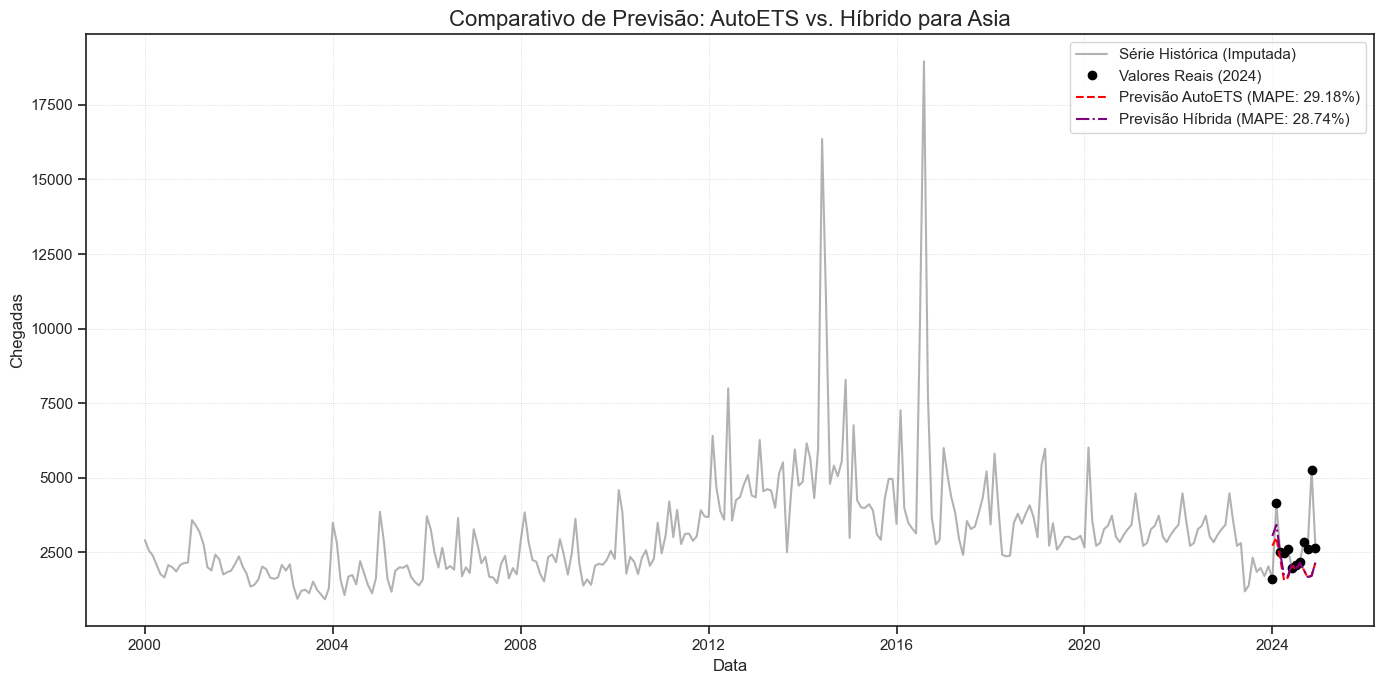


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ARIMA nos Resíduos: (2, 3, 0, 0, 1, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.8652
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.6620
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0979
   ✓ PASSA: Não há evidência de heterocedasticidade.


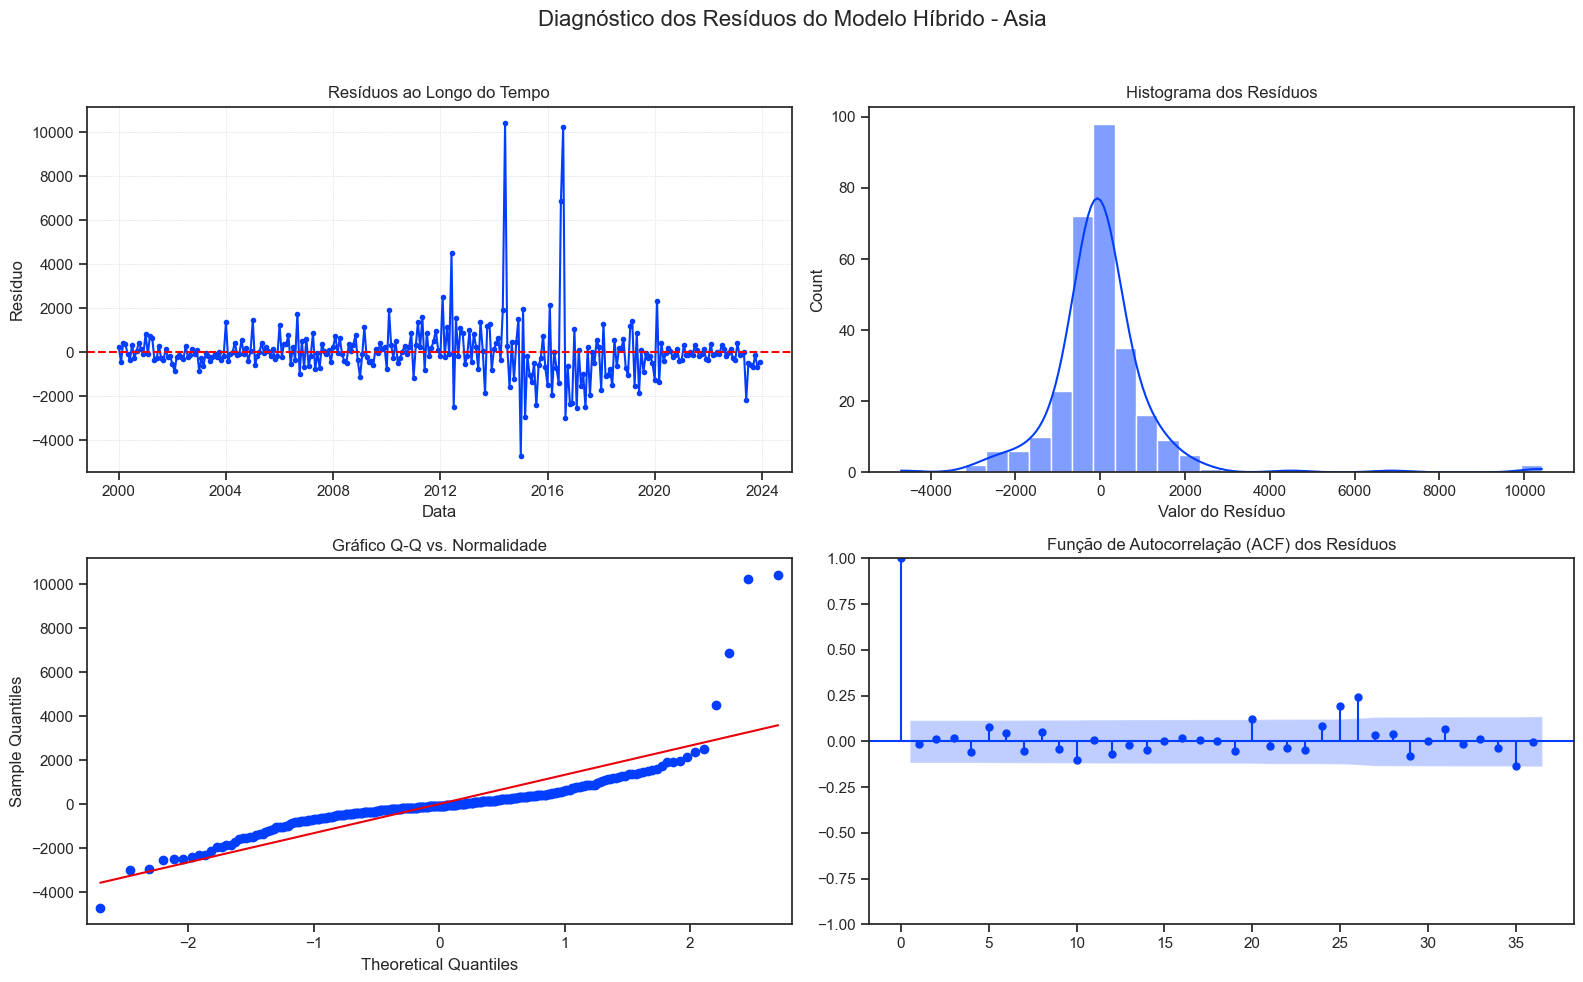


==================== Modelo Híbrido para: Europa ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS       -> RMSE: 5663.36, MAPE: 16.22%
Híbrido (ETS+ARIMA) -> RMSE: 5508.58, MAPE: 15.05%


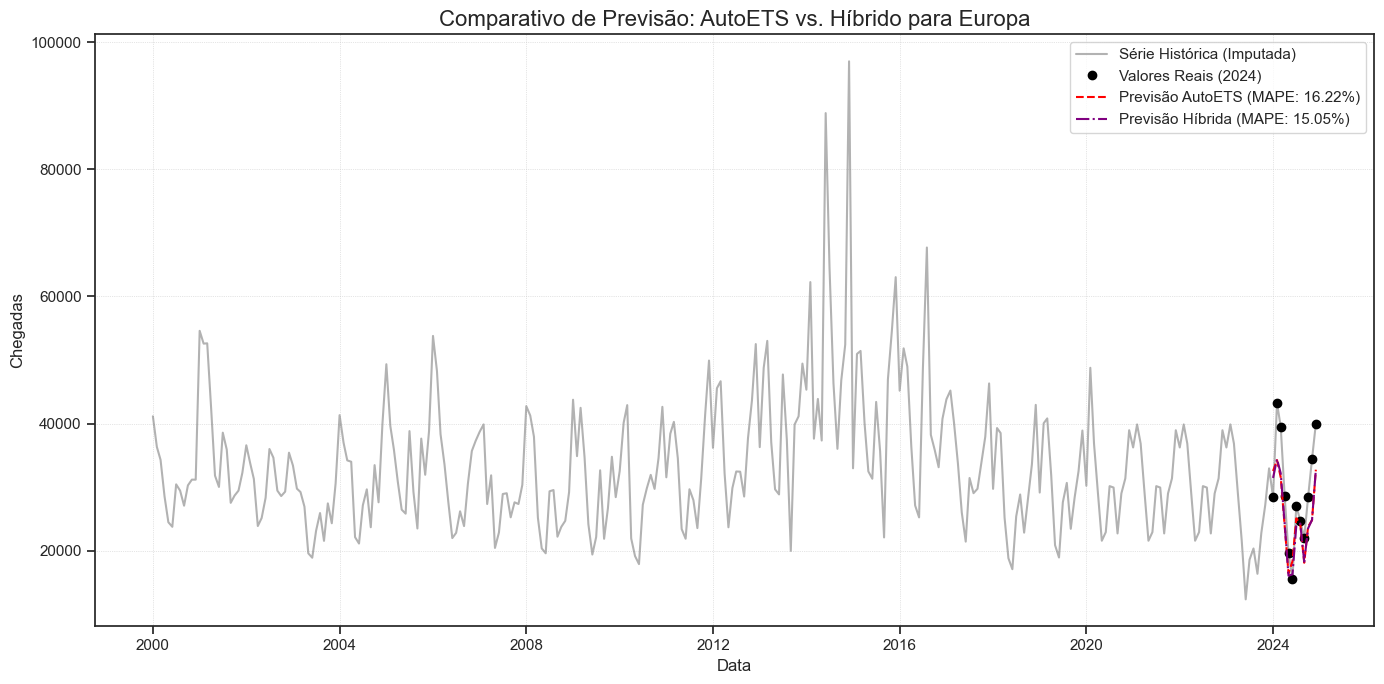


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ARIMA nos Resíduos: (2, 2, 2, 0, 12, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.8374
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0880
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0000
   ✗ FALHA: Heterocedasticidade detectada.


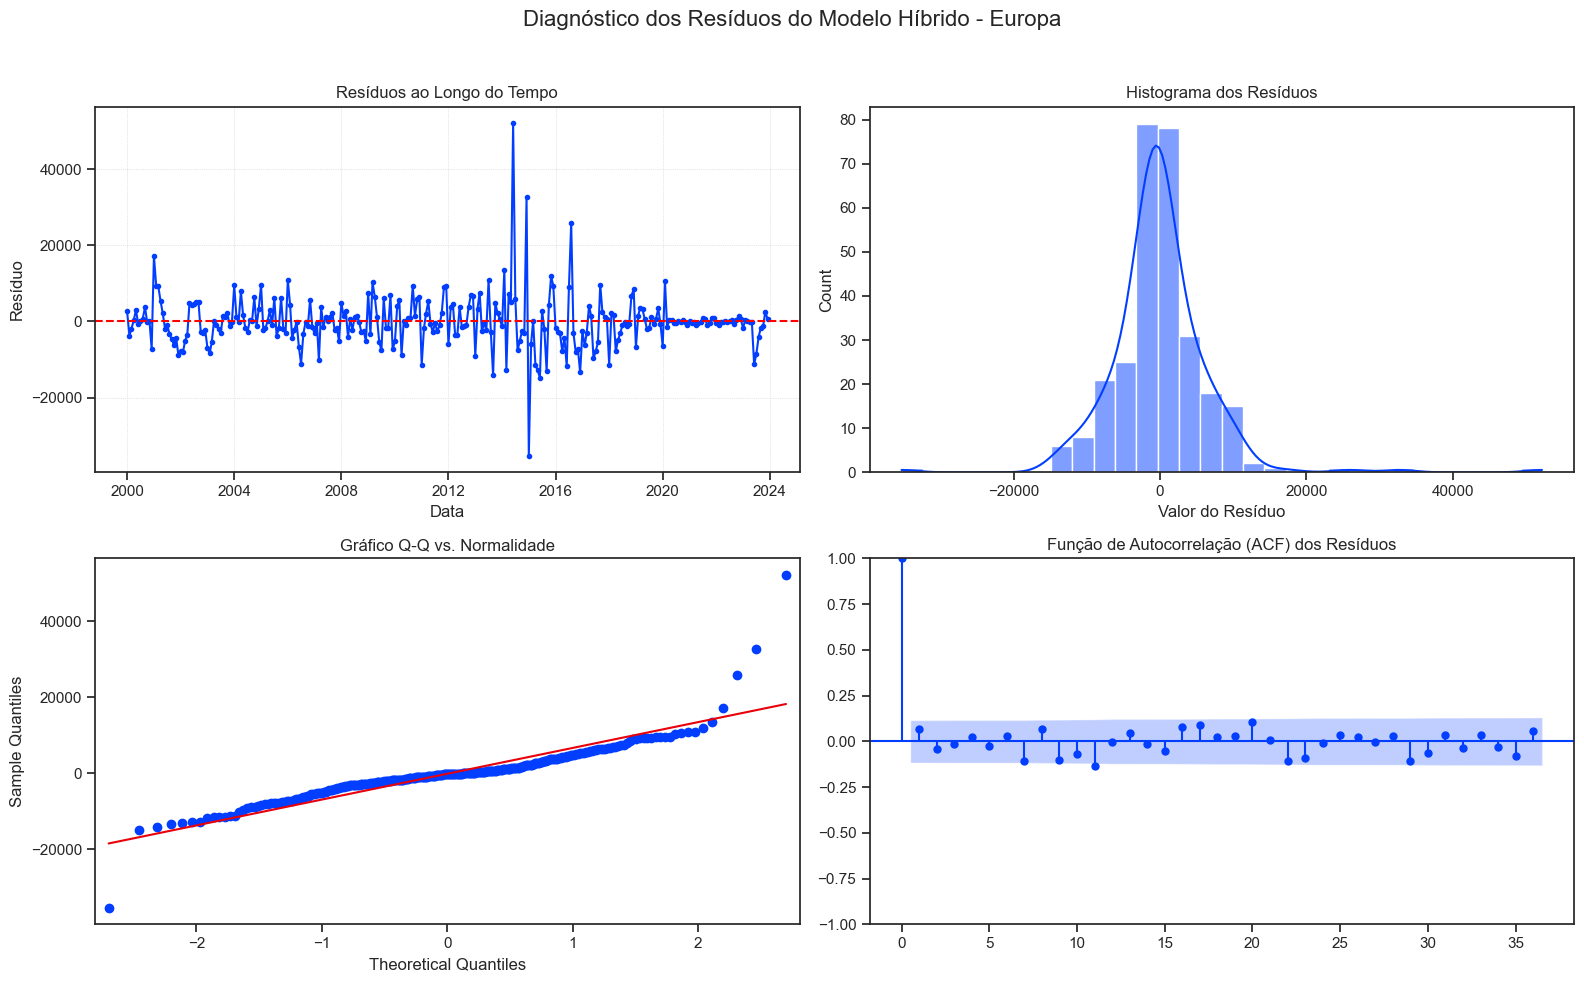


==================== Modelo Híbrido para: Oceania ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS       -> RMSE: 469.27, MAPE: 42.24%
Híbrido (ETS+ARIMA) -> RMSE: 437.21, MAPE: 41.88%


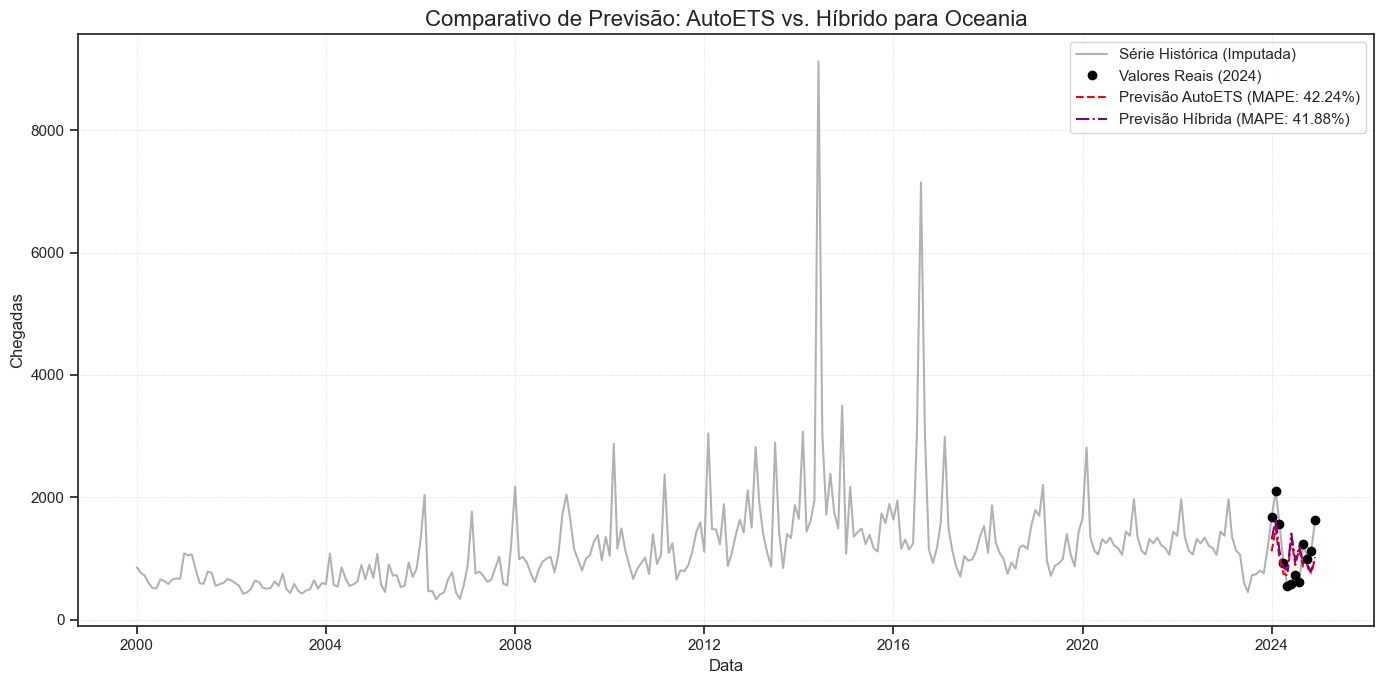


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ARIMA nos Resíduos: (1, 2, 0, 0, 1, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.5951
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.9722
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.9921
   ✓ PASSA: Não há evidência de heterocedasticidade.


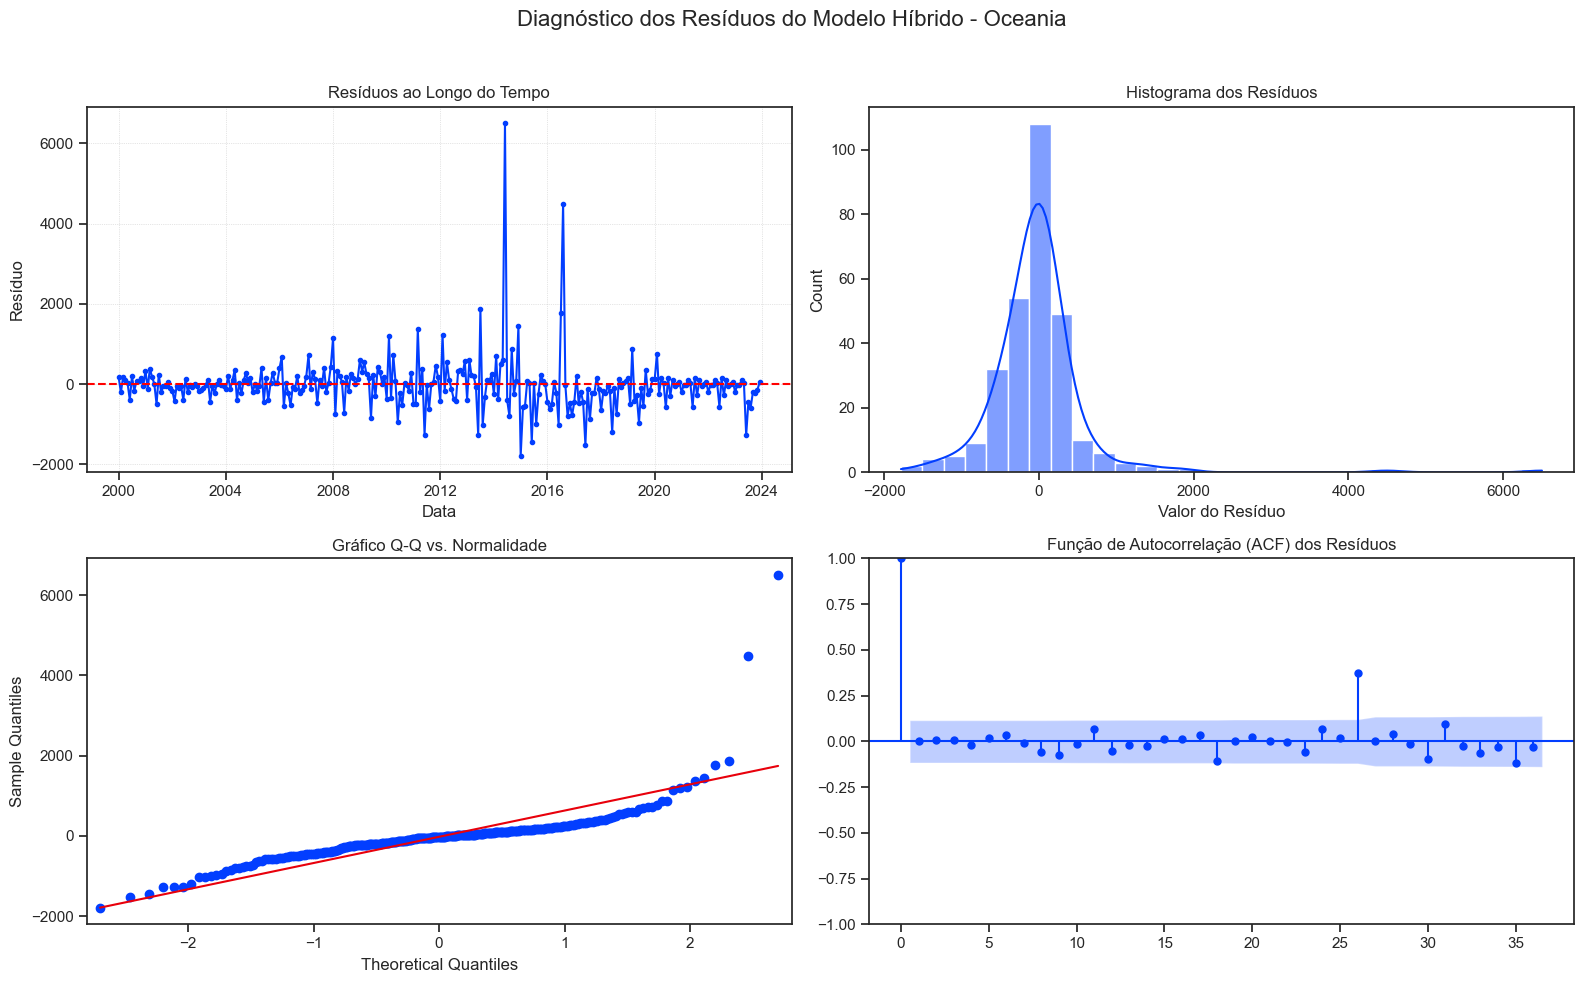

In [22]:
# --- Identificação dos Continentes com Autocorrelação nos Resíduos ---

print("--- Verificando Autocorrelação nos Resíduos do AutoETS por Continente ---")

continents_for_hybrid = []
# Itera sobre cada continente para verificar o teste de Ljung-Box
for continente in Y_df_h_imputado['unique_id'].unique():
    # Filtra os dados de treino
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()

    # Treina o modelo AutoETS para obter os resíduos
    sf_ets = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
    sf_ets.fit(df=train_df)
    
    # Extrai os resíduos
    residuals = sf_ets.fitted_[0][0].model_['residuals']

    # Realiza o teste de Ljung-Box
    if len(residuals) > 24:
        lb_test = acorr_ljungbox(residuals, lags=[24], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0]
        
        # Se o p-valor for menor que 0.05, há autocorrelação
        if lb_pvalue < 0.05:
            print(f"✗ {continente.title()}: Autocorrelação detectada (p-valor={lb_pvalue:.4f}). Adicionando ao modelo híbrido.")
            continents_for_hybrid.append(continente)
        else:
            print(f"✓ {continente.title()}: Sem autocorrelação significativa (p-valor={lb_pvalue:.4f}).")
    else:
        print(f"- {continente.title()}: Dados insuficientes para o teste de Ljung-Box.")

# --- Construção do Modelo Híbrido para os Continentes Selecionados ---

print("\n--- Construindo Modelos Híbridos (ETS+ARIMA) ---")

if not continents_for_hybrid:
    print("Nenhum continente apresentou autocorrelação nos resíduos. Modelo híbrido não é necessário.")
else:
    for continente in continents_for_hybrid:
        print(f"\n{'='*20} Modelo Híbrido para: {continente.title()} {'='*20}")

        # 1. Preparar os dados de treino e teste
        train_df = Y_df_h_imputado[
            (Y_df_h_imputado['unique_id'] == continente) &
            (Y_df_h_imputado['ds'] <= train_end)
        ].copy()
        test_series = series_por_continente[continente].loc[test_start:test_end]
        y_true_teste = test_series.values

        # 2. Treinar o modelo AutoETS base e obter previsões e resíduos
        sf_ets = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
        sf_ets.fit(df=train_df)
        forecast_ets = sf_ets.forecast(df = train_df, h=12, fitted=True)
        y_pred_ets = forecast_ets['AutoETS'].values
        
        # Métricas do modelo ETS original
        mape_ets = mean_absolute_percentage_error(y_true_teste, y_pred_ets) * 100
        rmse_ets = np.sqrt(mean_squared_error(y_true_teste, y_pred_ets))

        # DataFrame com os resíduos do ETS
        df_residuos = pd.DataFrame({
            'unique_id': f'{continente}_residuos',
            'ds': train_df['ds'],
            'y': sf_ets.fitted_[0][0].model_['actual_residuals']
        })

        # 3. Treinar AutoARIMA nos resíduos
        sf_arima_residuos = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS', n_jobs=1)
        sf_arima_residuos.fit(df=df_residuos)
        forecast_residuos = sf_arima_residuos.forecast(df = df_residuos, h=12, fitted=True)

        # 4. Criar a previsão híbrida
        y_pred_hibrido = y_pred_ets + forecast_residuos['AutoARIMA'].values

        # 5. Calcular métricas para o modelo híbrido
        mape_hibrido = mean_absolute_percentage_error(y_true_teste, y_pred_hibrido) * 100
        rmse_hibrido = np.sqrt(mean_squared_error(y_true_teste, y_pred_hibrido))

        print("\n--- Comparação de Performance no Teste (2024) ---")
        print(f"AutoETS       -> RMSE: {rmse_ets:.2f}, MAPE: {mape_ets:.2f}%")
        print(f"Híbrido (ETS+ARIMA) -> RMSE: {rmse_hibrido:.2f}, MAPE: {mape_hibrido:.2f}%")

        # 6. Plotar os resultados
        plt.figure(figsize=(14, 7))
        plt.plot(imputed_continent_series[continente], label='Série Histórica (Imputada)', color='gray', alpha=0.6)
        plt.plot(test_series.index, test_series.values, label='Valores Reais (2024)', color='black', marker='o', linestyle='None')
        plt.plot(forecast_ets['ds'], y_pred_ets, label=f'Previsão AutoETS (MAPE: {mape_ets:.2f}%)', color='red', linestyle='--')
        plt.plot(forecast_ets['ds'], y_pred_hibrido, label=f'Previsão Híbrida (MAPE: {mape_hibrido:.2f}%)', color='purple', linestyle='-.')
        
        plt.title(f'Comparativo de Previsão: AutoETS vs. Híbrido para {continente.title()}', fontsize=16)
        plt.xlabel('Data')
        plt.ylabel('Chegadas')
        plt.legend()
        plt.grid(True, which='both', linestyle=':', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # --- Análise de Resíduos do Modelo Híbrido ---
        print("\n--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---")
        
        # Obter previsões do ETS no treino
        y_pred_ets_treino = sf_ets.fitted_[0][0].model_['fitted']
        
        # Obter previsões do ARIMA nos resíduos do ETS no treino
        fitted_residuos = sf_arima_residuos.forecast_fitted_values()

        y_pred_arima_residuos_treino = fitted_residuos['AutoARIMA'].values + y_pred_ets_treino
        
        # Calcular os resíduos do modelo híbrido no treino
        hybrid_residuals = train_df['y'].values - y_pred_arima_residuos_treino

        print(f"Modelo ARIMA nos Resíduos: {sf_arima_residuos.fitted_[0][0].model_['arma']}")

        # 1. Teste T para Média Zero
        print("\n1. Teste T para Média Zero:")
        if len(hybrid_residuals) > 1:
            t_stat, t_pvalue = ttest_1samp(hybrid_residuals, 0)
            print(f"   p-valor: {t_pvalue:.4f}")
            if t_pvalue > 0.05:
                print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.")
            else:
                print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero.")
        else:
            print("   Não foi possível realizar o Teste T.")

        # 2. Teste de Ljung-Box para Autocorrelação
        print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
        if len(hybrid_residuals) > 24:
            lb_test = acorr_ljungbox(hybrid_residuals, lags=[24], return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].iloc[0]
            print(f"   p-valor: {lb_pvalue:.4f}")
            if lb_pvalue > 0.05:
                print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.")
            else:
                print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.")
        else:
            print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

        # 3. Teste de Jarque-Bera para Normalidade
        print("\n3. Teste de Jarque-Bera (Normalidade):")
        if len(hybrid_residuals) > 1:
            jb_stat, jb_pvalue = stats.jarque_bera(hybrid_residuals)
            print(f"   p-valor: {jb_pvalue:.4f}")
            if jb_pvalue > 0.05:
                print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos.")
            else:
                print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.")
        else:
            print("   Não foi possível realizar o Teste de Jarque-Bera.")

        # 4. Teste ARCH para Heterocedasticidade
        print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
        try:
            arch_test = het_arch(hybrid_residuals, nlags=12)
            arch_pvalue = arch_test[1]
            print(f"   p-valor: {arch_pvalue:.4f}")
            if arch_pvalue > 0.05:
                print("   ✓ PASSA: Não há evidência de heterocedasticidade.")
            else:
                print("   ✗ FALHA: Heterocedasticidade detectada.")
        except Exception as e:
            print(f"   Não foi possível realizar o Teste ARCH: {e}")

        # --- Plots de Diagnóstico do Modelo Híbrido ---
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle(f'Diagnóstico dos Resíduos do Modelo Híbrido - {continente.replace("_", " ").title()}', fontsize=16)

        # Plot 1: Resíduos ao longo do tempo
        axes[0, 0].plot(train_df['ds'], hybrid_residuals, marker='o', linestyle='-', markersize=3)
        axes[0, 0].axhline(0, color='red', linestyle='--')
        axes[0, 0].set_title('Resíduos ao Longo do Tempo')
        axes[0, 0].set_xlabel('Data')
        axes[0, 0].set_ylabel('Resíduo')
        axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

        # Plot 2: Histograma dos resíduos
        sns.histplot(hybrid_residuals, kde=True, ax=axes[0, 1], bins=30)
        axes[0, 1].set_title('Histograma dos Resíduos')
        axes[0, 1].set_xlabel('Valor do Resíduo')

        # Plot 3: Gráfico Q-Q (Quantil-Quantil)
        sm.qqplot(hybrid_residuals, line='s', ax=axes[1, 0])
        axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

        # Plot 4: Gráfico de Autocorrelação (ACF)
        sm.graphics.tsa.plot_acf(hybrid_residuals, ax=axes[1, 1], lags=36)
        axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()